## Analysis of simulation

Here the 100 simulated images are imported and analyzed in terms of extracted LED position, fitted circle radius and center; especially compared to nominal values.  
Additionally the number of LEDs (8 originally) is reduced to 3 in two constellations (choose between symmetrical and asymmetrical).  
The corresponding positions and circles are compared to the case of fitting to 8 LEDs.

In [1]:
import logging

import os
import numpy as np
from time import sleep, time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

from astropy.coordinates import SkyCoord
import astropy.units as u

from ctapipe.coordinates import CameraFrame

from ctapointing.config import (
    Config,
)

from ctapointing.camera import FlashCam, MAGICCam
from ctapointing.coordinates import SkyCameraFrame
from ctapointing.exposure import Exposure
from ctapointing.exposure.utils import plot_exposure, plot_spots, plot_coords
from ctapointing.imagesolver import SpotExtractor, LEDFitter

from ctapointing.exposure.exposure_simulator import ExposureSimulator


from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
## self implemented helping methods
def print_unique_infos(array, __name):
    print(f"\nshape of {__name}:", array.shape)
    
    unique = np.unique(array)
    print(f"unique values in {__name}:", unique)
    
    unique_dict = {}
    for i in unique:
        unique_dict[i] = np.count_nonzero(array == i)
    
    print(unique_dict)


### plotting ###
def setFonts(fontsize):
    plt.rc('font', size=fontsize) #controls default text size
    plt.rc('axes', titlesize=fontsize) #fontsize of the title
    plt.rc('axes', labelsize=fontsize) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=fontsize) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=fontsize) #fontsize of the y tick labels
    plt.rc('legend', fontsize=fontsize) #fontsize of the legend

In [3]:
# prevent multiple log lines
try: 
    log
except NameError:
    log = logging.getLogger()
    log.setLevel(logging.INFO)

    handler = logging.StreamHandler()
    handler.setLevel(logging.INFO)
    log.addHandler(handler)



In [4]:
Config.read_config('test_MAGIC_MAGICmask_CvE')
Config.image_path = "/Users/mhein/ctapointing/images"
Config.mask_path = "/Users/mhein/ctapointing/ctapointing/data/masks"
# Config.print()

General parameters

By setting ```CONSTELLATION_3LED``` the constellation of 3 LEDs to fit the circle (camera center) can by chosen as "sym" and "asym"

In [5]:
# NUMBER_OF_SIMULATIONS = 10
# realtive path (subfolder) or absolute path to folder, where simulated exposures are saved
SIMULATION_PATH = "simulations_15s/"
SIMULATION_META_PATH = "simulations_meta/"

PLOT_PATH = "plots/"

_triangular = [1, 3, 5, 7, 10]
_one_sided = [0, 1, 7, 8, 10]

CONSTELLATION_3LED = "sym"
# CONSTELLATION_3LED = "asym"

if CONSTELLATION_3LED == "sym":
    turn_off_led = _triangular # [1, 3, 4, 7, 10] #[3, 4, 5, 7, 8] # 0-11
    _constellation_indices = [0, 4, 8]
elif CONSTELLATION_3LED == "asym":
    turn_off_led = _one_sided # [1, 3, 4, 7, 10] #[3, 4, 5, 7, 8] # 0-11
    _constellation_indices = [3, 4, 5]
    
### the indexing of the LEDs; negative indives are the LEDs not operational on the telescope
#          0
#     1       -11
#  -2              10
# 3                 -9
#  4              8
#     5        7
#         -6
###

#### Different transformations between chip system and science camera system

In [16]:
CHIP_PIXEL_TO_METER = 5.4e-6 # by exposure.camera.pixel_size
CHIP_METER_TO_PIXEL = 1 / CHIP_PIXEL_TO_METER

FOCAL_LENGTH_CHIP = 50e-3 # m # by exposure.camera.focal_length
FOCAL_LENGTH_SCIENECAM = 17 # m # by sciencecamera.focal_length

TO_RAD = 180/np.pi
TO_ARCSEC = 3600

def chip_meter_to_pixel(chip_meter):
    return chip_meter * CHIP_METER_TO_PIXEL

def chip_pixel_to_meter(chip_pixel):
    return chip_pixel * CHIP_PIXEL_TO_METER


def scienceCam_to_chip(sc_coord):
    """
    transform coordinates from science camera [m] to chip coordinates [pix]
    """
    chip_meter = sc_coord * FOCAL_LENGTH_CHIP / FOCAL_LENGTH_SCIENECAM
    
    return chip_meter_to_pixel(chip_meter)

def chip_to_scienceCam(chip_pix_coord):
    """
    transform coordinates from chip coordinates [pix] to science camera [m]
    """
    chip_meter = chip_pixel_to_meter(chip_pix_coord)

    sc_coord = chip_meter * FOCAL_LENGTH_SCIENECAM / FOCAL_LENGTH_CHIP
    
    return sc_coord


def scienceCam_to_arcsec(sc_coord):
    """
    transform lengths in science camera coordinates [m] to arcsec
    """
    return sc_coord / FOCAL_LENGTH_SCIENECAM * TO_RAD * TO_ARCSEC

def chip_to_arcsec(chip_pix_coord):
    """
    transform lengths in chip coordinates [pix] to arcsec
    """
    return chip_pixel_to_meter(chip_pix_coord) / FOCAL_LENGTH_CHIP * TO_RAD * TO_ARCSEC

sc_m = 1e-3

c_p = scienceCam_to_chip(sc_m)
print(c_p)

sc_m2 = chip_to_scienceCam(c_p)
print(sc_m2)

print(chip_to_arcsec(c_p))
print(scienceCam_to_arcsec(sc_m))
print(scienceCam_to_arcsec(sc_m2))

chip_to_scienceCam(3.1952693)

0.5446623093681918
0.001
12.133223896888023
12.13322389688802
12.13322389688802


0.0058665144348

Setup SpotExtractor and LEDFitter

In [6]:
led_extractor = SpotExtractor.from_name(Config.led_extractor_config_name)
print(led_extractor)

led_fitter = LEDFitter()
print(led_fitter)

SpotExtractor(uuid=22fb5cc3-b03b-4164-a993-0c2b5ee53282, name=thresh_0.2_MAGICmask_LED, detection_threshold=0.2, kernel_size=10, use_tophat_kernel=True), min_spot_distance=10.0


Load nominal LED positions and nominal center

In [17]:
true_led_positions = np.loadtxt(f"{SIMULATION_META_PATH}led_positions.txt")
true_led_positions

array([[1757.03048042, 1844.86424541],
       [1710.84867356, 1673.10950489],
       [1585.00950592, 1547.43405252],
       [1413.28686026, 1501.48130313],
       [1241.68638419, 1547.505243  ],
       [1116.09168374, 1673.07795048],
       [1070.03241919, 1844.58337776],
       [1115.85715854, 2016.26172496],
       [1241.45165612, 2142.20823413],
       [1413.28686026, 2188.50857955],
       [1585.24456857, 2142.56091984],
       [1711.08377799, 2016.71700972]])

In [18]:
true_sc_centre = np.loadtxt(f"{SIMULATION_META_PATH}sc_centre.txt")
true_sc_centre

array([1413.28686026, 1844.72371159])

Try out if the center fitted to nominal LED positions matches the nominal center position

In [1]:
### try circle fit of nominal LED positions
_not = [2, 6, 9, 11]

mask = []
for i in range(12):
    if i in _not: mask.append(False)
    else: mask.append(True)

# print(mask)


l_pos = np.copy(true_led_positions)[mask]
# print(l_pos)

ledDict = {
    "coord_x" : l_pos[:,0],
    "coord_y" : l_pos[:,1]
}

center_, r, rot, used = led_fitter.process(ledDict)

print("Fitted center positions:", center_)
print("Distance between fitted and nominal center:")
print(center_ - true_sc_centre, "pix")
print(chip_to_arcsec(center_ - true_sc_centre), "arcsec")

NameError: name 'np' is not defined

Next up:
- Load a simulated image each at a time  
- Extract spots  
- Fit circle 
- Save important information in variables
    - absolute LED positions
    - difference to nominal LED positions
    - center position and radius of fitted circle
- discard LED positions to 3 LEDs and save the corresponding results 

In [20]:
## list all FITS files in the given directory, sorted by name
list_of_fits_files = sorted(os.listdir(SIMULATION_PATH))
# print(list_of_fits_files)

led_positions = []
led_positions_diff = []
led_positions_off = []

circle_center = []
circle_radii = []
circle_center_off = [] 
circle_radii_off = []

constr_indices = []
extr_indices = []
constr_indices_off = []
extr_indices_off = []

process_up_to = -1 # -1 for 'all'

if process_up_to > 0:
    n_files = process_up_to 
else:
    n_files = len(list_of_fits_files)

c = 0
for fits_file in list_of_fits_files:
    if (process_up_to > 0) and (c >= process_up_to): break
    c+=1

    clear_output(wait=True)
    log.info(f"Loading simulation {c} / {n_files}\n")
    
    ## load simulated exposure from FITS file
    exposure = Exposure.from_name(f"{SIMULATION_PATH}{fits_file}", read_meta_from_fits=True)

    ## extract spots
    ledlist = led_extractor.process(exposure)
    extracted_led_coords = np.array([ledlist["coord_x"], ledlist["coord_y"]]).T
    
    extracted_indices = []
    constructed_indices = []

    for extr_idx, led_pos_extr in enumerate(extracted_led_coords):
        diff = np.absolute(true_led_positions - led_pos_extr).sum(axis=1)
        true_idx = diff.argmin()

        constructed_indices.append(true_idx)
        extracted_indices.append(extr_idx)

    led_argsort_idx = np.argsort(constructed_indices)

    extracted_indices = [ extracted_indices[i] for i in led_argsort_idx ]
    constructed_indices = [ constructed_indices[i] for i in led_argsort_idx ]

    constr_indices.append(constructed_indices)
    extr_indices.append(extracted_indices)

    ### always do a circle fit on all extracted leds
    ### also save filtered led positions
    ## fit circle
    (cx, cy), r, rot, filtered_led_coords = led_fitter.process(ledlist)
    
    circle_center.append([cx, cy])
    circle_radii.append(r)

    # ## TODO: sort for LED
    # filtered_led_coords = np.array([ filtered_led_coords[i] for i in led_argsort_idx ])

    led_positions.append(filtered_led_coords)
    led_positions_diff.append(filtered_led_coords[extracted_indices] - true_led_positions[constructed_indices])


    ### if there are leds turned off, do a separate circle fit
    if len(turn_off_led) is not 0:
        ## sort the led positions to count ccw, beginning at upper position
        ## maintain matching indices
        sort_indices = np.argsort(constructed_indices)
        extracted_indices = [ extracted_indices[i] for i in sort_indices 
                                                    if constructed_indices[i] not in turn_off_led ]
        constructed_indices = [ constructed_indices[i] for i in sort_indices 
                                                    if constructed_indices[i] not in turn_off_led ]

        ## use the extracted_indices to only select the information of ledlist, where leds are not off
        (cx_off, cy_off), r_off, rot_off, filtered_led_coords_off = led_fitter.process(ledlist[extracted_indices])

        circle_center_off.append([cx_off, cy_off])
        circle_radii_off.append(r_off)

        led_positions_off.append(filtered_led_coords_off)

        constr_indices_off.append(constructed_indices)
        extr_indices_off.append(extracted_indices)

Loading simulation 100 / 100

reading image from file simulations_15s/simulation_000099.fits
loading image from simulations_15s/simulation_000099.fits
no TEMP keyword in file
estimating image background
removed 0 spots that are closer to each other than min_spot_distance=10.0.
removed 0 spots that are close to edge of dilated image mask with dilation_radius=10.0.
extracted 8 spots.
performing circle prefit
similarity transform using 8 spots
performing circle prefit
similarity transform using 3 spots


In [22]:
print("extracted led_positions:", np.shape(led_positions))
print("led_positions_diff:", np.shape(led_positions_diff))
print("led_positions_off:", np.shape(led_positions_off))

print("circle_center:", np.shape(circle_center))
print("circle_radii:", np.shape(circle_radii))

extracted led_positions: (100, 8, 2)
led_positions_diff: (100, 8, 2)
led_positions_off: (100, 3, 2)
circle_center: (100, 2)
circle_radii: (100,)


In [21]:
print("constr 8:", constr_indices[-1])
print("extr 8:", extr_indices[-1])
print("constr 3:", constr_indices_off[-1])
print("extr 3:", extr_indices_off[-1])

constr 8: [0, 1, 3, 4, 5, 7, 8, 10]
extr 8: [2, 1, 6, 7, 5, 3, 0, 4]
constr 3: [0, 4, 8]
extr 3: [2, 7, 0]


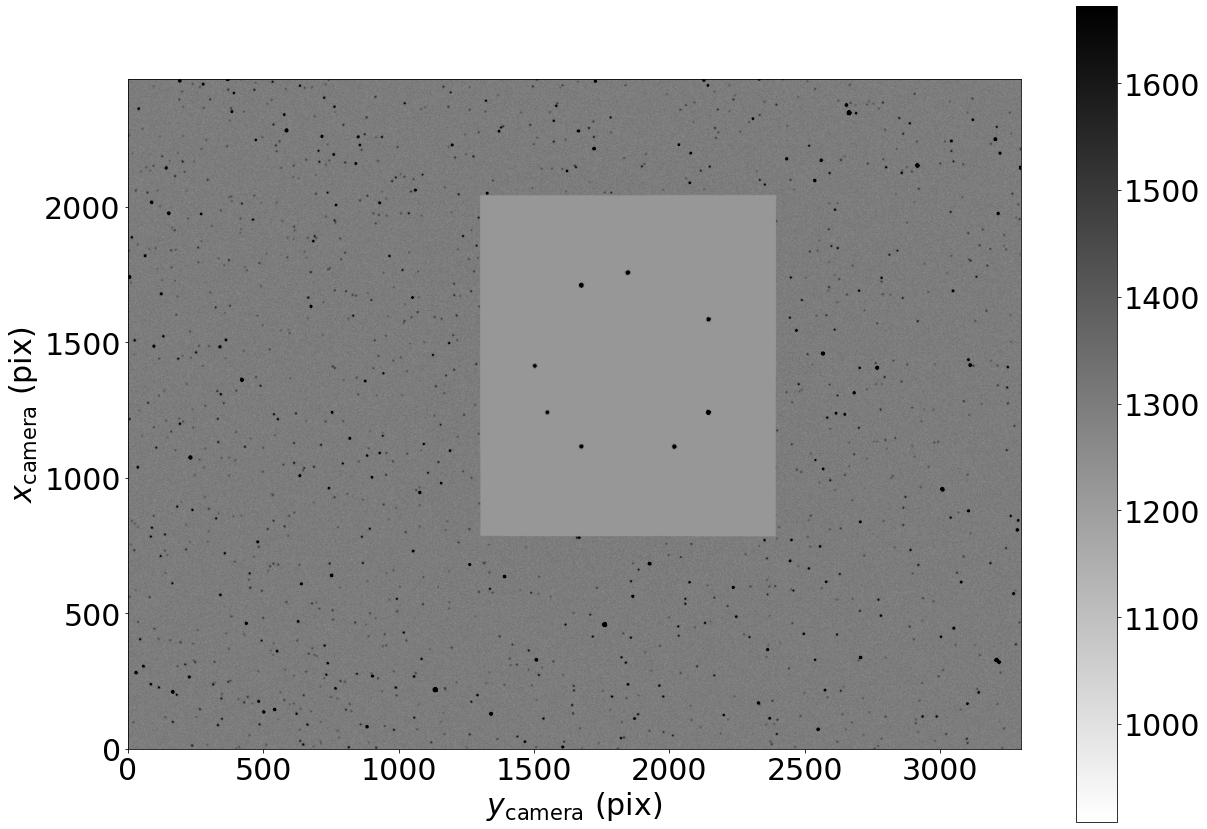

In [28]:
setFonts(30)

im = plot_exposure(exposure)
ax = im.axes
fig = im.figure

emptyPlot = False
if emptyPlot:
    
    # TODO: acurate labeling
    # TODO: could show excluded spots
    # for led_nr in range(len(filtered_led_coords)):
    # for led_extr, led_constr in zip(extr_indices[-1], constr_indices[-1]):
    # # for led_nr in indices:
    #     if led_extr == 7:
    #         ax.plot(filtered_led_coords[led_extr][1], filtered_led_coords[led_extr][0], "ko", fillstyle="none", markersize=10, label=f"led {led_constr}")
    #     else:
    #         ax.plot(filtered_led_coords[led_extr][1], filtered_led_coords[led_extr][0], "o", fillstyle="none", markersize=10, label=f"led {led_constr}")

    plot_spots(ledlist, ax=ax, label=f'extracted LED spots ({len(ledlist)})', color='cyan')

    # fitted circle
    led_centre = np.array([cx, cy]).reshape(1,2)
    # plot_coords(led_centre, ax=ax, label="fitted camera centre (final fit)", marker="P", color="red")
    led_circle = plt.Circle((cy, cx), r, color='r', linestyle='-', fill=False, label="LED full fit")
    ax.add_patch(led_circle)

    # ax.plot(exposure.camera.chip_centre[1], exposure.camera.chip_centre[0], 'P', markersize=15, 
    #         color='r', fillstyle='none', label='chip origin')

    ax.plot(
        led_centre[:, 1],
        led_centre[:, 0],
        label="fitted camera center",
        marker="P",
        markersize=15,
        color="red",
        linestyle="none",
        fillstyle="none",
        # alpha=alpha,
    )
    # if filtered_led_coords is not None:
    #     plot_coords(filtered_led_coords, ax=ax, label=f'fitted LED spots (final fit, {len(filtered_led_coords)})', marker='+', color='red')


    ax.plot(filtered_led_coords[:,1], filtered_led_coords[:,0], label=f'fitted LED spots ({len(filtered_led_coords)})', marker='o', color='orange', fillstyle="none", linestyle="none", markersize=18, markeredgewidth=2)

    ax.legend()

fig.colorbar(im)
plt.show()

if emptyPlot:
    im.figure.savefig(f"{PLOT_PATH}simulation-empty.pdf")
else:
    im.figure.savefig(f"{PLOT_PATH}simulation.pdf")

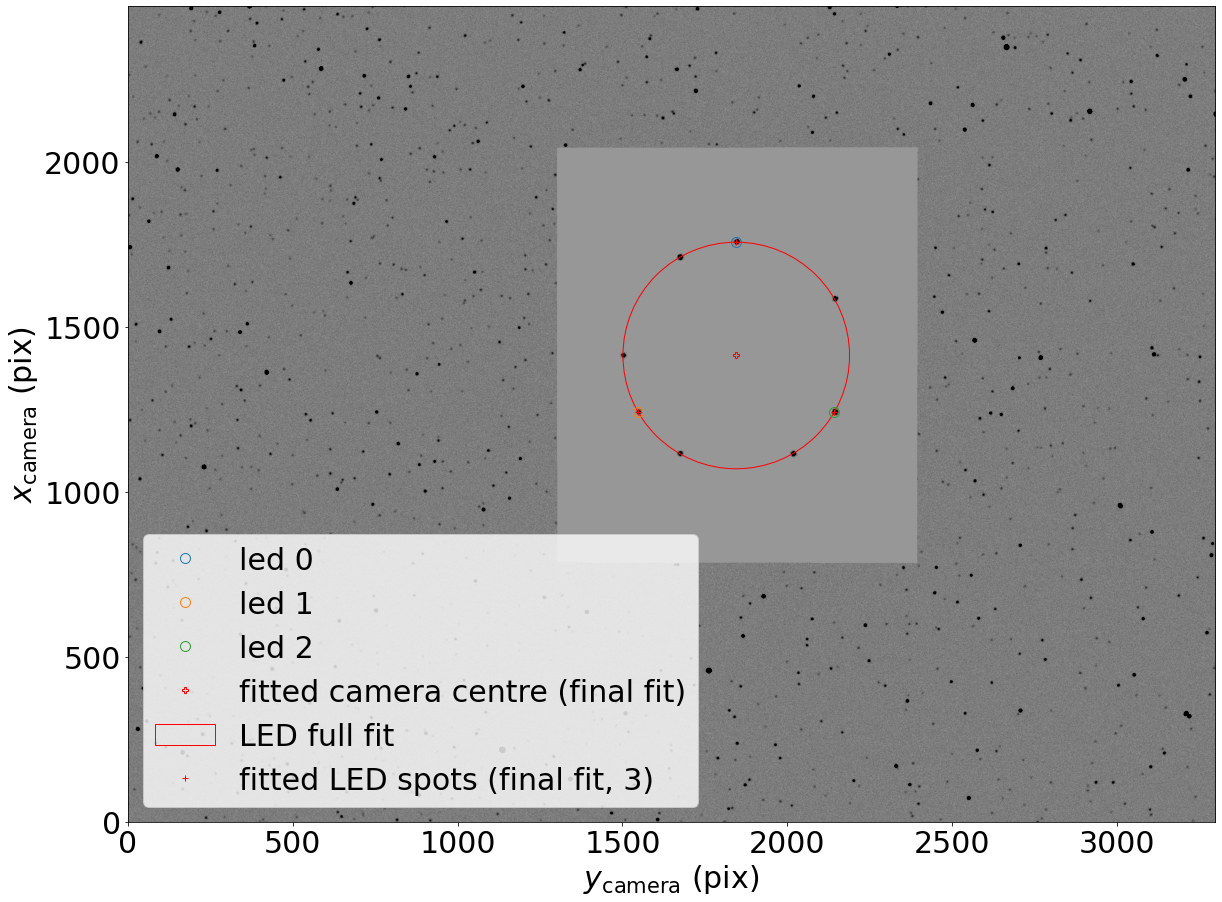

In [30]:
im = plot_exposure(exposure)
ax = im.axes

# TODO: acurate labeling
# TODO: could show excluded spots
# numbering is wrong now, but does not matter for now
for led_nr in range(len(filtered_led_coords_off)):
# for led_nr in indices:
    if led_nr == 7:
        ax.plot(filtered_led_coords_off[led_nr][1], filtered_led_coords_off[led_nr][0], "ko", fillstyle="none", markersize=10, label=f"led {led_nr}")
    else:
        ax.plot(filtered_led_coords_off[led_nr][1], filtered_led_coords_off[led_nr][0], "o", fillstyle="none", markersize=10, label=f"led {led_nr}")

# fitted circle
if r is not None:
    led_centre = np.array([cx_off, cy_off]).reshape(1,2)
    plot_coords(led_centre, ax=ax, label="fitted camera centre (final fit)", marker="P", color="red")
    led_circle = plt.Circle((cy_off, cx_off), r_off, color='r', linestyle='-', fill=False, label="LED full fit")
    ax.add_patch(led_circle)

    # ax.plot(exposure.camera.chip_centre[1], exposure.camera.chip_centre[0], 'P', markersize=15, 
    #         color='r', fillstyle='none', label='chip origin')

if filtered_led_coords_off is not None:
    plot_coords(filtered_led_coords_off, ax=ax, label=f'fitted LED spots (final fit, {len(filtered_led_coords_off)})', marker='+', color='red')



ax.legend()
plt.show()

im.figure.savefig(f"{PLOT_PATH}sim_3led_constellation_{CONSTELLATION_3LED}.pdf")

## Create Histograms

The function to create the histograms is implemented once.  
The mean, standard deviation and standard error on the mean are calculaetd for the distribution and returned.  
The functionality to fit a Gaussian to the distribution is not used in the end.

In [31]:
def latex_table(mean_std_meanErr):
    print("means:")
    print(f"${mean_std_meanErr[0]:.3f} \pm {mean_std_meanErr[2]:.3f}$")
    
    print("std:")
    print(f"${mean_std_meanErr[1]:.3f}$")

In [32]:
def gaussian(x, mu, sigma):
    gauss = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5 * ((x - mu) / sigma)**2 )
    return gauss

def hist_and_gaussFit(
    hist_data, 
    label=None, 
    bins=30, 
    p0=None, 
    ax=None,
    xlabel = "x axis",
    ylabel = "counts",
    mu_sigma_unit = "pix",
    # sigma_unit = "pix",
    autoplot=True,
    pixel_to_arcsec=False,
    no_gaussian=True,
    force_return_in_pix = False
    ) -> tuple:
    ### return the mean value, standard devitaion and standard error on the mean of the distribution

    # TODO: delete:
    ylabel="counts"
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))

    ## create histogram
    # TODO: number of bins??

    mu_unit = mu_sigma_unit
    sigma_unit = mu_sigma_unit

    mean = np.mean(hist_data)
    std = np.std(hist_data, ddof=1)
    mean_err = std / np.sqrt(len(hist_data))

    print(f"mean: {mean} {mu_unit}")
    print(f"std: {std} {sigma_unit}")
    print(f"mean error: {mean_err}  {mu_unit}")


    hist, h_bins, _ = ax.hist(hist_data, label=label, bins=bins)
    # print(hist)
    # print(bins)
    # print(len(hist))
    # print(len(bins))

    # bin center: lower + (upper-lower)/2
    bin_width = h_bins[1] - h_bins[0]
    bins_center = h_bins[:-1] + (h_bins[1:] - h_bins[:-1]) / 2


    # if pixel_to_arcsec:
    #     print("bins in pix:")
    #     print(bin_width)
    #     print(bins_center)

    #     bin_width = chip_to_arcsec(bin_width)
    #     bins_center = chip_to_arcsec(bins_center)
        
    #     print("bins in arcsec:")
    #     print(bin_width)
    #     print(bins_center)


    ## fit normal distribution
    if p0 is None:
        p0 = [bins_center[np.argmax(hist)], 0.1]

    popt, pcov = curve_fit(
        gaussian, 
        bins_center, 
        hist, 
        p0=p0, 
        # sigma=np.sqrt(hist), 
        absolute_sigma=True
    )
    # print(pcov)
    perr = np.sqrt(np.diag(pcov))

    print("")
    # print("p0: \t mu: {:.5f}, sigma: {:.5f}".format(*p0))
    print("popt: \t mu: {:.5f} pix, sigma: {:.5f} pix".format(*popt))
    # print("pcov:\n", pcov)
    print("perr: \t mu: {:.5f} pix, sigma: {:.5f} pix".format(*perr))


    # ax.plot(bins_center, hist, "x")
    min_ = 100
    if len(bins_center) > min_:
        n = 2*len(bins_center)
    else:
        n = min_

    # label_mu = f"$\mu = {popt[0]:.5f}$\n $\pm {perr[0]:.5f}$ {mu_unit}"
    # label_sigma = f"$\sigma = {popt[1]:.5f}$\n $\pm {perr[1]:.5f}$ {sigma_unit}"
    label_mu = f"$\mu = {mean:.2f} \pm {mean_err:.2f}$ {mu_unit}"
    label_sigma = f"$\sigma = {std:.2f}$ {sigma_unit}"
    
    x_g = np.linspace(bins_center[0] - 3*bin_width, bins_center[-1] + 3*bin_width, n)
    y_g = gaussian(x_g, *popt)

    _return = (mean, std, mean_err)

    if pixel_to_arcsec:
        # chip_to_arcsec

        mu_unit = "arcsec"
        sigma_unit = "arcsec"

        mean_arcsec = chip_to_arcsec(mean)
        std_arcsec = chip_to_arcsec(std)
        mean_err_arcsec = chip_to_arcsec(mean_err)

        print("")
        print(f"mean: {mean_arcsec} {mu_unit}")
        print(f"std: {std_arcsec} {sigma_unit}")
        print(f"mean error: {mean_err_arcsec}  {mu_unit}")

        popt_arcsec = chip_to_arcsec(popt)
        perr_arcsec = chip_to_arcsec(perr)

        print("")
        # print("p0: \t mu: {:.5f}, sigma: {:.5f}".format(*p0))
        print("popt: \t mu: {:.5f} arcsec, sigma: {:.5f} arcsec".format(*popt_arcsec))
        # print("pcov:\n", pcov)
        print("perr: \t mu: {:.5f} arcsec, sigma: {:.5f} arcsec".format(*perr_arcsec))

        # label_mu = f"$\mu = {popt_arcsec[0]:.5f}$\n $\pm {perr_arcsec[0]:.5f}$ {mu_unit}"
        # label_sigma = f"$\sigma = {popt_arcsec[1]:.5f}$\n $\pm {perr_arcsec[1]:.5f}$ {sigma_unit}"
        label_mu = f"$\mu = {mean_arcsec:.2f} \pm {mean_err_arcsec:.2f}$ {mu_unit}"
        label_sigma = f"$\sigma = {std_arcsec:.2f}$ {sigma_unit}"

        # x_g = chip_to_arcsec(x_g)
        # y_g = chip_to_arcsec(y_g)

        if not force_return_in_pix:
            _return = (mean_arcsec, std_arcsec, mean_err_arcsec)
    

    color = "orange"
    alpha_lines = 0
    if not no_gaussian:
        ax.plot(x_g, y_g, "-", color=color, label="gaussian fit")
    alpha_lines = 1
        
    ax.vlines(
        #x_g[np.argmax(y_g)], 0, np.max(y_g), 
        mean, 0, np.max(hist),
        linewidths=3,
        ls="dotted", color=color, alpha=alpha_lines,
        label=label_mu
    )
    
    # ax.hlines(
    #     0.61*np.max(y_g), x_g[np.argmax(y_g)], x_g[np.argmax(y_g)]+popt[1], 
    #     ls="--", color=color, alpha=alpha_lines,
    #     label=label_sigma
    # )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend()

    if autoplot:
        plt.show()

    return _return

Difference between extracted led position and hard coded led position

In [33]:
###################
nrows=2
ncols=1
###################

800 x positions
mean: 0.06354879059465589 pix
std: 0.11553354380115825 pix
mean error: 0.004084727613815601  pix

popt: 	 mu: 0.05870 pix, sigma: -0.03810 pix
perr: 	 mu: 0.00307 pix, sigma: 0.00250 pix

mean: 1.4156509297583517 arcsec
std: 2.573694434936123 arcsec
mean error: 0.09099383938227062  arcsec

popt: 	 mu: 1.30769 arcsec, sigma: -0.84865 arcsec
perr: 	 mu: 0.06832 arcsec, sigma: 0.05579 arcsec


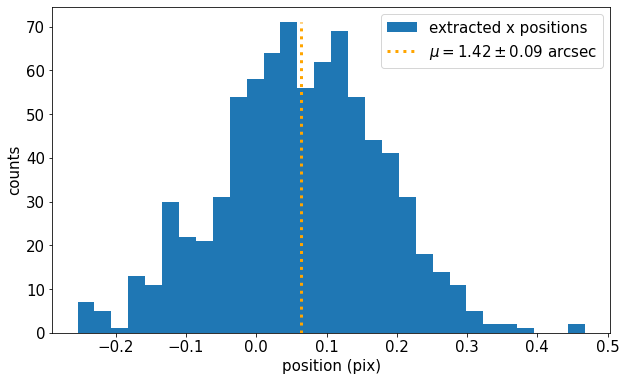


800 y positions
mean: 0.07102906996319916 pix
std: 0.11304179425729625 pix
mean error: 0.003996630963841436  pix

popt: 	 mu: 0.07453 pix, sigma: -0.02548 pix
perr: 	 mu: 0.00163 pix, sigma: 0.00133 pix

mean: 1.5822861142180382 arcsec
std: 2.5181867293529767 arcsec
mean error: 0.08903134563097316  arcsec

popt: 	 mu: 1.66030 arcsec, sigma: -0.56764 arcsec
perr: 	 mu: 0.03641 arcsec, sigma: 0.02973 arcsec


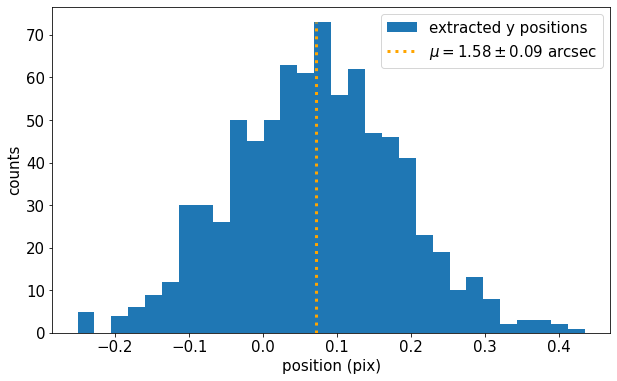

In [35]:
setFonts(15)
fs = (10, 6)
# fig, (ax1, ax2) = plt.subplots(figsize=(12*ncols,8*nrows), nrows=nrows, ncols=ncols)
fig, ax1 = plt.subplots(figsize=fs)

pos_x = np.reshape(np.array(led_positions_diff)[:,:,0], (-1))
print(len(pos_x), "x positions")

hist_and_gaussFit(
    pos_x, 
    label="extracted x positions", 
    bins=30, 
    xlabel="position (pix)", 
    ylabel="normalized counts",
    ax=ax1,
    autoplot=False,
    pixel_to_arcsec=True
)


plt.show()

fig.savefig(f"{PLOT_PATH}sim_extracted_spot-nominal_all-x.pdf")


fig, ax2 = plt.subplots(figsize=fs)
print("")
pos_y = np.reshape(np.array(led_positions_diff)[:,:,1], (-1))
print(len(pos_y), "y positions")

hist_and_gaussFit(
    pos_y,
    label="extracted y positions", 
    bins=30, 
    xlabel="position (pix)", 
    ylabel="normalized counts",
    ax=ax2,
    autoplot=False,
    pixel_to_arcsec=True,
    # no_gaussian=True
)

plt.show()

fig.savefig(f"{PLOT_PATH}sim_extracted_spot-nominal_all-y.pdf")

Each led separately

100 x positions
mean: 0.0763689471595444 pix
std: 0.12550733028508318 pix
mean error: 0.012550733028508319  pix

popt: 	 mu: 0.12010 pix, sigma: 0.00680 pix
perr: 	 mu: inf pix, sigma: inf pix

mean: 1.7012404176290816 arcsec
std: 2.795876477695045 arcsec
mean error: 0.2795876477695045  arcsec

popt: 	 mu: 2.67535 arcsec, sigma: 0.15141 arcsec
perr: 	 mu: inf arcsec, sigma: inf arcsec
100 y positions

mean: 0.059920850212447474 pix
std: 0.11433597385989508 pix
mean error: 0.011433597385989508  pix

popt: 	 mu: 0.02072 pix, sigma: 0.00807 pix
perr: 	 mu: nan pix, sigma: nan pix

mean: 1.33483275639703 arcsec
std: 2.5470166494907076 arcsec
mean error: 0.2547016649490708  arcsec

popt: 	 mu: 0.46155 arcsec, sigma: 0.17967 arcsec
perr: 	 mu: nan arcsec, sigma: nan arcsec


/Users/mhein/opt/anaconda3/envs/ctapointing-dev/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/99/b84mj5610_9d9mqzs91dxdg400017j/T/ipykernel_43007/3708700892.py:79: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


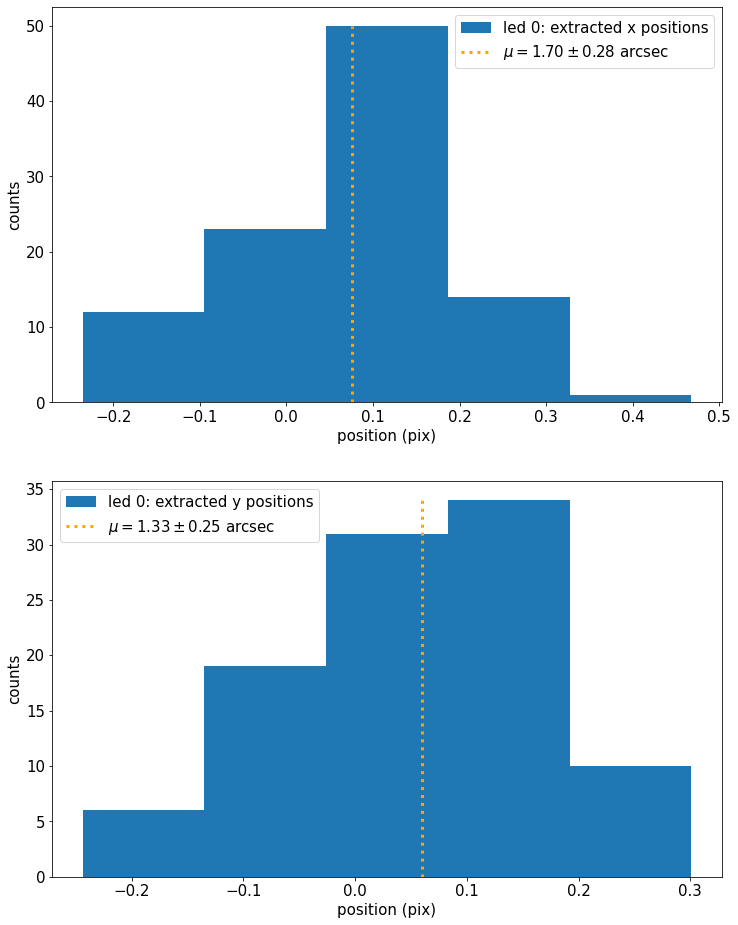

100 x positions
mean: 0.06504592167136253 pix
std: 0.11072429077913858 pix
mean error: 0.011072429077913858  pix

popt: 	 mu: 0.02890 pix, sigma: 0.01289 pix
perr: 	 mu: nan pix, sigma: nan pix

mean: 1.449001918516399 arcsec
std: 2.4665606335158667 arcsec
mean error: 0.24665606335158669  arcsec

popt: 	 mu: 0.64390 arcsec, sigma: 0.28713 arcsec
perr: 	 mu: nan arcsec, sigma: nan arcsec
100 y positions

mean: 0.0849079548651298 pix
std: 0.113611906869091 pix
mean error: 0.011361190686909101  pix

popt: 	 mu: 0.09132 pix, sigma: -0.00641 pix
perr: 	 mu: nan pix, sigma: nan pix

mean: 1.8914604687820658 arcsec
std: 2.530886899433351 arcsec
mean error: 0.2530886899433351  arcsec

popt: 	 mu: 2.03428 arcsec, sigma: -0.14285 arcsec
perr: 	 mu: nan arcsec, sigma: nan arcsec


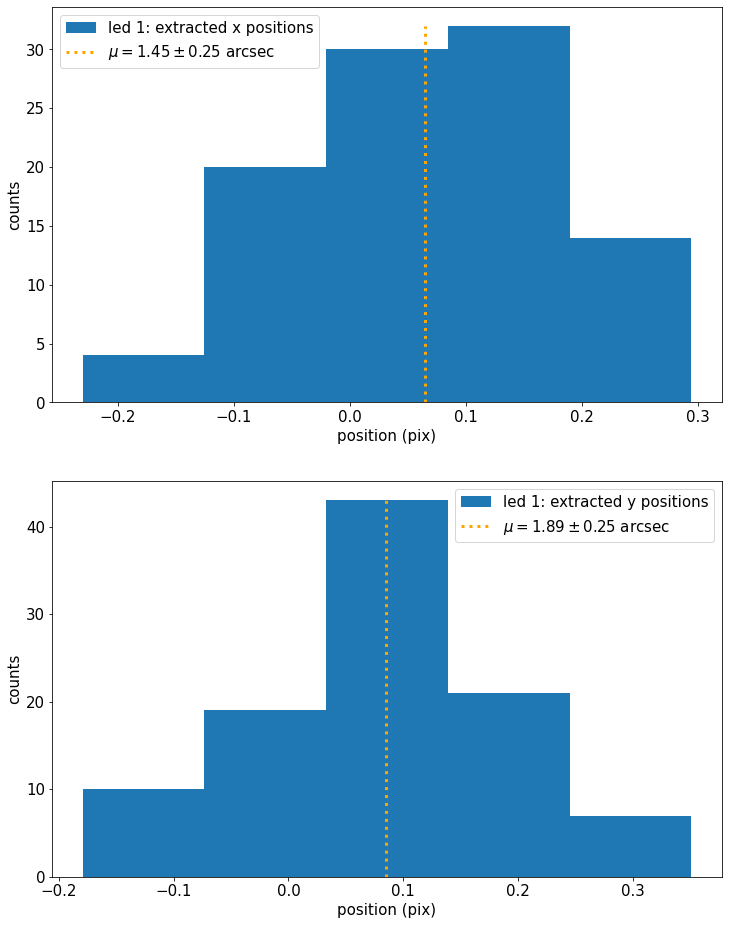

100 x positions
mean: 0.062315768691496486 pix
std: 0.11504445984520631 pix
mean error: 0.01150444598452063  pix

popt: 	 mu: 0.11239 pix, sigma: 0.00932 pix
perr: 	 mu: 103670.05614 pix, sigma: 20714.59906 pix

mean: 1.3881833951713627 arcsec
std: 2.5627993077355202 arcsec
mean error: 0.256279930773552  arcsec

popt: 	 mu: 2.50377 arcsec, sigma: 0.20772 arcsec
perr: 	 mu: 2309416.27674 arcsec, sigma: 461450.81835 arcsec
100 y positions

mean: 0.08689266613712789 pix
std: 0.1030210340778265 pix
mean error: 0.010302103407782651  pix

popt: 	 mu: 0.13106 pix, sigma: 0.01017 pix
perr: 	 mu: inf pix, sigma: inf pix

mean: 1.935673086067378 arcsec
std: 2.2949582724113466 arcsec
mean error: 0.22949582724113468  arcsec

popt: 	 mu: 2.91959 arcsec, sigma: 0.22660 arcsec
perr: 	 mu: inf arcsec, sigma: inf arcsec


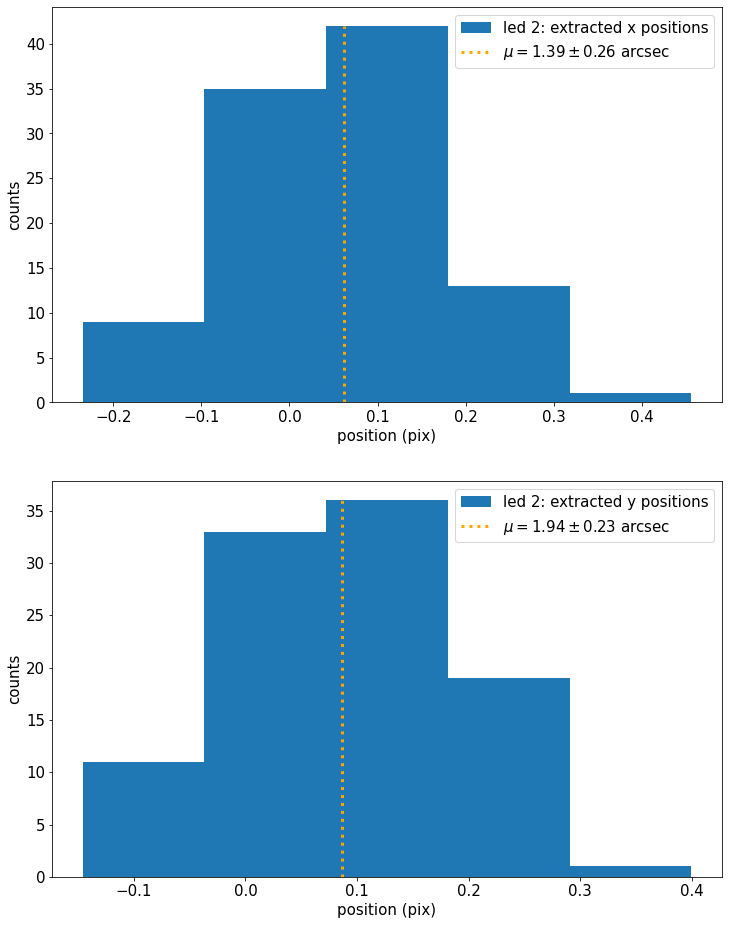

100 x positions
mean: 0.07362923360286913 pix
std: 0.10936429362857687 pix
mean error: 0.010936429362857688  pix

popt: 	 mu: 0.04297 pix, sigma: -0.00710 pix
perr: 	 mu: nan pix, sigma: nan pix

mean: 1.6402089171475438 arcsec
std: 2.436264522250088 arcsec
mean error: 0.2436264522250088  arcsec

popt: 	 mu: 0.95714 arcsec, sigma: -0.15826 arcsec
perr: 	 mu: nan arcsec, sigma: nan arcsec
100 y positions

mean: 0.0638146211082676 pix
std: 0.10611072519282523 pix
mean error: 0.010611072519282522  pix

popt: 	 mu: 0.03016 pix, sigma: 0.00760 pix
perr: 	 mu: nan pix, sigma: nan pix

mean: 1.4215727295318978 arcsec
std: 2.363786082644794 arcsec
mean error: 0.23637860826447943  arcsec

popt: 	 mu: 0.67189 arcsec, sigma: 0.16920 arcsec
perr: 	 mu: nan arcsec, sigma: nan arcsec


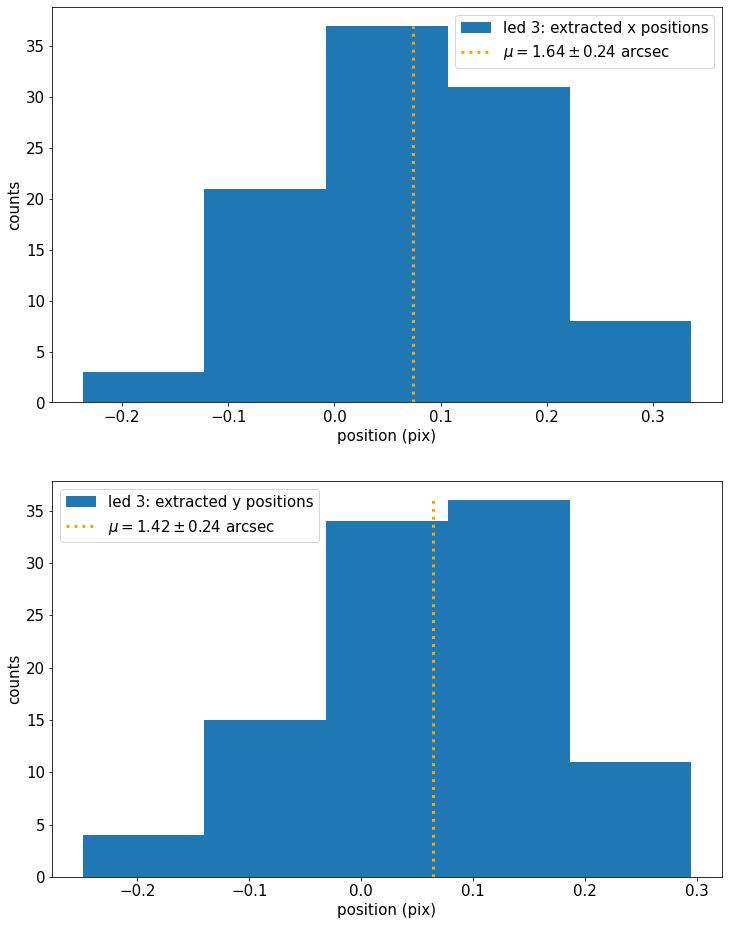

100 x positions
mean: 0.04924521834343068 pix
std: 0.1226409809526614 pix
mean error: 0.01226409809526614  pix

popt: 	 mu: 0.07072 pix, sigma: 0.00641 pix
perr: 	 mu: 9199.67727 pix, sigma: 75674.45448 pix

mean: 1.097015985381998 arcsec
std: 2.73202396280869 arcsec
mean error: 0.27320239628086906  arcsec

popt: 	 mu: 1.57532 arcsec, sigma: 0.14269 arcsec
perr: 	 mu: 204937.52209 arcsec, sigma: 1685769.48272 arcsec
100 y positions

mean: 0.0768224691159503 pix
std: 0.11640397163288735 pix
mean error: 0.011640397163288735  pix

popt: 	 mu: 0.08382 pix, sigma: -0.00925 pix
perr: 	 mu: 160694.38130 pix, sigma: 13363.77558 pix

mean: 1.711343344423503 arcsec
std: 2.5930846067670013 arcsec
mean error: 0.2593084606767001  arcsec

popt: 	 mu: 1.86728 arcsec, sigma: -0.20597 arcsec
perr: 	 mu: 3579724.30588 arcsec, sigma: 297699.47062 arcsec


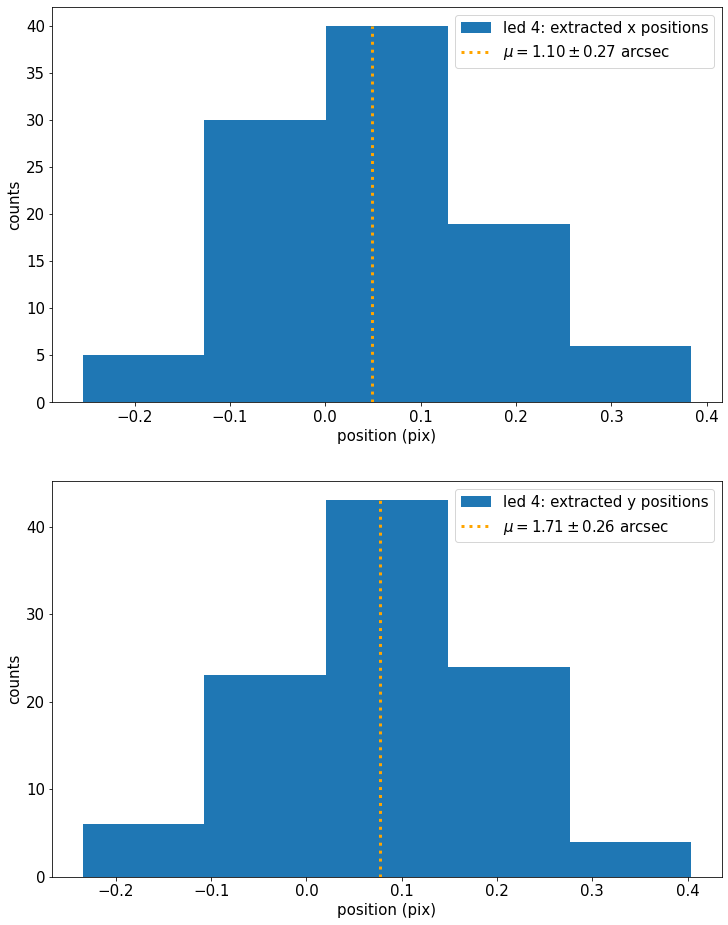

100 x positions
mean: 0.05763028040209974 pix
std: 0.11295801093288936 pix
mean error: 0.011295801093288937  pix

popt: 	 mu: 0.05877 pix, sigma: 0.01084 pix
perr: 	 mu: 49657.08699 pix, sigma: 65536.00000 pix

mean: 1.2838066510793331 arcsec
std: 2.51632032182602 arcsec
mean error: 0.251632032182602  arcsec

popt: 	 mu: 1.30925 arcsec, sigma: 0.24146 arcsec
perr: 	 mu: 1106191.01820 arcsec, sigma: 1459919.19696 arcsec
100 y positions

mean: 0.061116838572761484 pix
std: 0.11007937031736997 pix
mean error: 0.011007937031736997  pix

popt: 	 mu: 0.00476 pix, sigma: 0.00891 pix
perr: 	 mu: 24147.77483 pix, sigma: 14821.81873 pix

mean: 1.361475309597737 arcsec
std: 2.4521939989539865 arcsec
mean error: 0.24521939989539862  arcsec

popt: 	 mu: 0.10613 arcsec, sigma: 0.19846 arcsec
perr: 	 mu: 537930.29852 arcsec, sigma: 330179.71341 arcsec


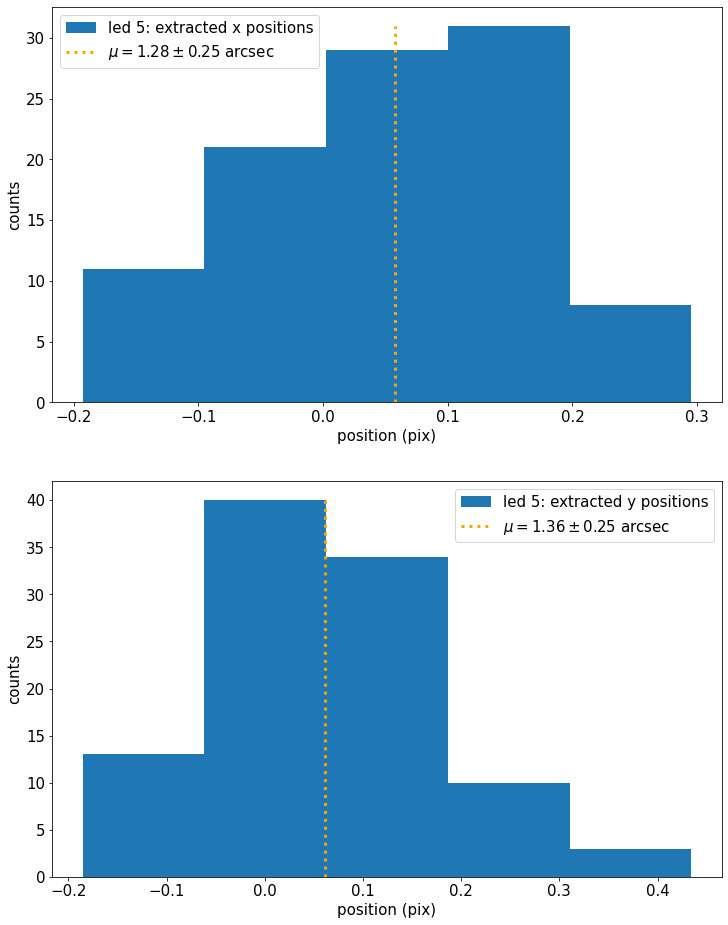

100 x positions
mean: 0.07778235891826625 pix
std: 0.10880854334855601 pix
mean error: 0.0108808543348556  pix

popt: 	 mu: 0.06539 pix, sigma: 0.00562 pix
perr: 	 mu: inf pix, sigma: inf pix

mean: 1.7327264247055756 arcsec
std: 2.4238842960764186 arcsec
mean error: 0.24238842960764181  arcsec

popt: 	 mu: 1.45674 arcsec, sigma: 0.12518 arcsec
perr: 	 mu: inf arcsec, sigma: inf arcsec
100 y positions

mean: 0.07493481617135331 pix
std: 0.11317588835843728 pix
mean error: 0.011317588835843728  pix

popt: 	 mu: 0.08893 pix, sigma: -0.01048 pix
perr: 	 mu: inf pix, sigma: inf pix

mean: 1.669292856584565 arcsec
std: 2.521173889882376 arcsec
mean error: 0.2521173889882376  arcsec

popt: 	 mu: 1.98114 arcsec, sigma: -0.23354 arcsec
perr: 	 mu: inf arcsec, sigma: inf arcsec


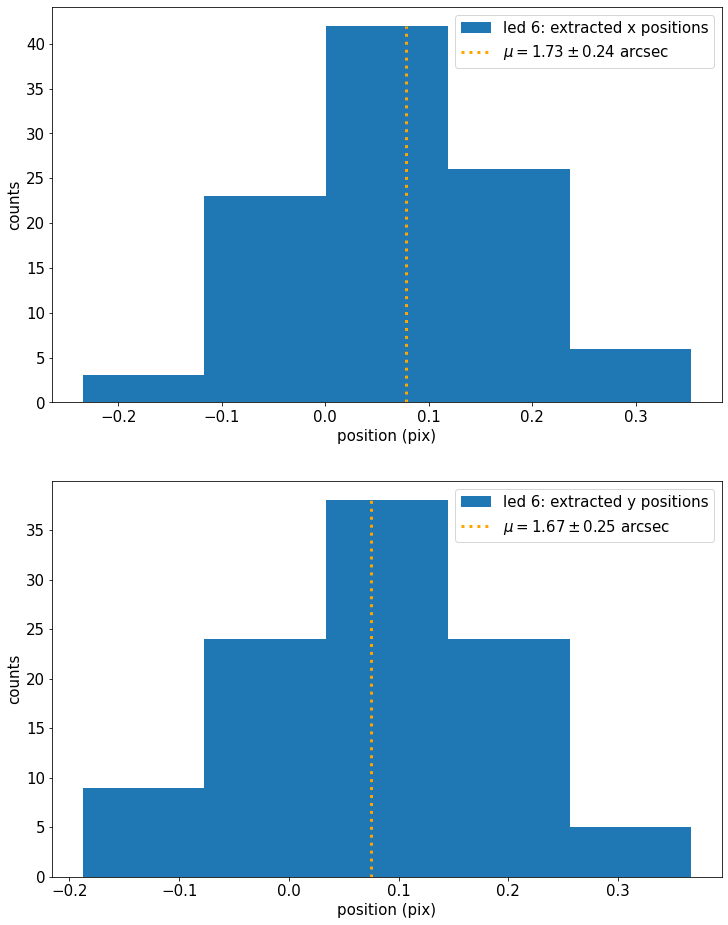

100 x positions
mean: 0.046372595968177846 pix
std: 0.11774250461206674 pix
mean error: 0.011774250461206674  pix

popt: 	 mu: 0.05803 pix, sigma: -0.00844 pix
perr: 	 mu: nan pix, sigma: nan pix

mean: 1.0330237284355173 arcsec
std: 2.622902569292426 arcsec
mean error: 0.2622902569292426  arcsec

popt: 	 mu: 1.29279 arcsec, sigma: -0.18791 arcsec
perr: 	 mu: nan arcsec, sigma: nan arcsec
100 y positions

mean: 0.05982234352255546 pix
std: 0.12609669883303043 pix
mean error: 0.012609669883303042  pix

popt: 	 mu: 0.06310 pix, sigma: 0.00918 pix
perr: 	 mu: inf pix, sigma: inf pix

mean: 1.332638362360131 arcsec
std: 2.8090056045448963 arcsec
mean error: 0.2809005604544896  arcsec

popt: 	 mu: 1.40561 arcsec, sigma: 0.20441 arcsec
perr: 	 mu: inf arcsec, sigma: inf arcsec


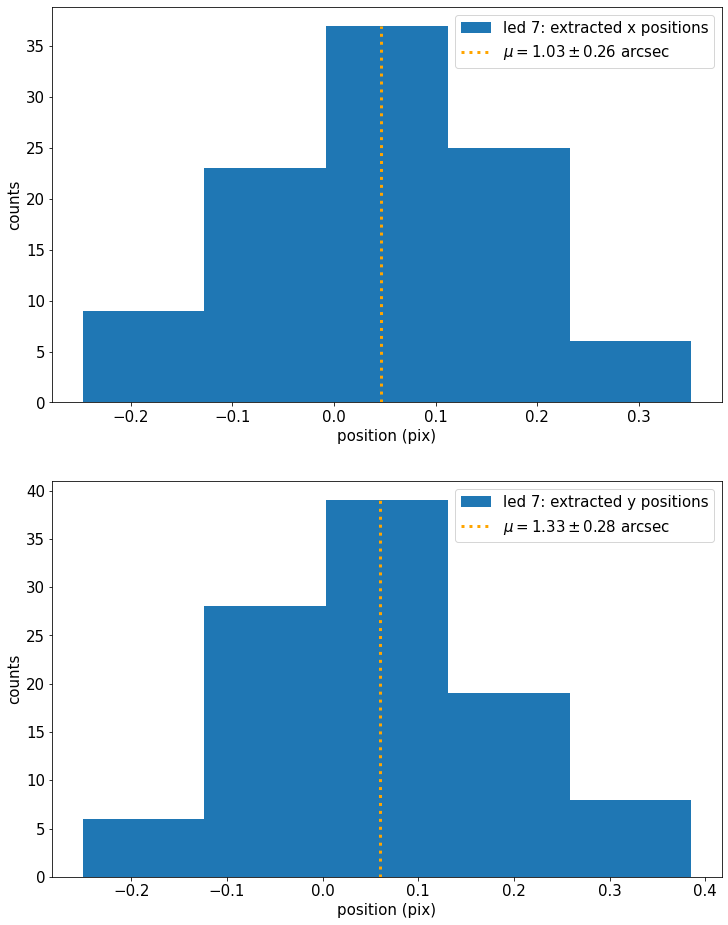

In [37]:
led_means_stds_x = []
led_means_stds_y = []

for n_led in range(np.shape(led_positions_diff)[1]):
    fig, (ax1, ax2) = plt.subplots(figsize=(12*ncols,8*nrows), nrows=nrows, ncols=ncols)

    pos_x = np.reshape(np.array(led_positions_diff)[:,n_led,0], (-1))
    print(len(pos_x), "x positions")

    mean_std_meanerr_x = hist_and_gaussFit(
        pos_x, 
        label=f"led {n_led}: extracted x positions", 
        bins=5, 
        xlabel="position (pix)", 
        ylabel="normalized counts",
        ax=ax1,
        autoplot=False,
        pixel_to_arcsec=True
    )


    pos_y = np.reshape(np.array(led_positions_diff)[:,n_led,1], (-1))
    print(len(pos_y), "y positions")


    print("")
    mean_std_meanerr_y = hist_and_gaussFit(
        pos_y,
        label=f"led {n_led}: extracted y positions", 
        bins=5, 
        xlabel="position (pix)", 
        # xlabel="position (arcsec)", 
        ylabel="normalized counts",
        # mu_sigma_unit="arcsec",
        ax=ax2,
        autoplot=False,
        pixel_to_arcsec=True
    )    

    led_means_stds_x.append(list(mean_std_meanerr_x))
    led_means_stds_y.append(list(mean_std_meanerr_y))

    plt.show()

In [38]:
np.shape(led_means_stds_x)

(8, 3)

Plot the mean value of each LED with the standard error on the mean as error bars

[2, 1, 6, 7, 5, 3, 0, 4]
[0, 1, 3, 4, 5, 7, 8, 10]
1.4156509297583513 arcsec
0.0944633324058545 arcsec


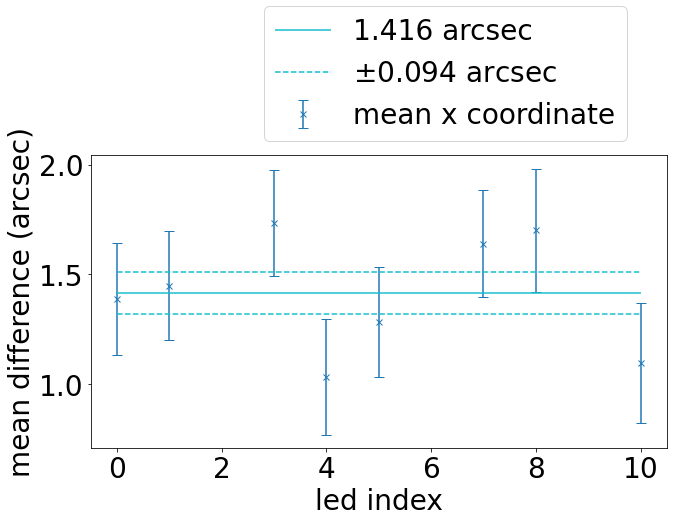

1.5822861142180384 arcsec
0.08892617755329116 arcsec


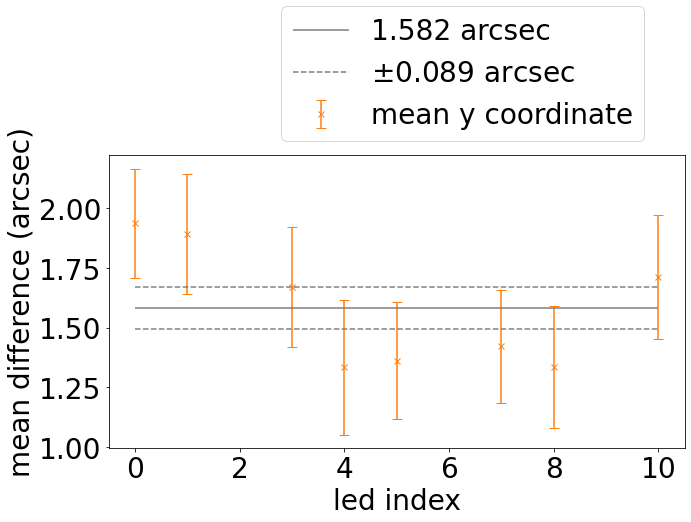

In [40]:
setFonts(28)
fs = (10, 8)

unit = "arcsec"

print(extr_indices[-1])
print(constr_indices[-1])

# fig, (ax1, ax2) = plt.subplots(figsize=(12*ncols,8*nrows), nrows=nrows, ncols=ncols)
fig, ax1 = plt.subplots(figsize=fs)

label = "mean x coordinate"
# for led_idx, msm in enumerate(led_means_stds_x):
for led_extr, led_constr in zip(extr_indices[-1], constr_indices[-1]):

    led_idx = led_constr
    msm = led_means_stds_x[led_extr]

    # print(led_extr, led_idx)
    # print(led_positions[-1][led_extr])

    ax1.errorbar(
        led_idx, msm[0], 
        yerr=msm[2],
        fmt="x", color="tab:blue", 
        capsize=5,
        # ecolor="cyan",
        label=label, #fr"$\rho_y = {100 * corr_coeff_y[0] :.1f} \%$", 
    )
    label=None



###
# for x
### 
means = np.array(led_means_stds_x)[:, 0]
mean_trend = means.mean()
mean_std = means.std(ddof=1)
mean_trend_err = mean_std / np.sqrt(len(means))

print(mean_trend, unit) 
print(mean_trend_err, unit)

# ax.hlines(0.0, 0, len(led_means_stds_x)-1, linestyles="dashed", color="tab:blue", )
ax1.hlines(mean_trend, 0, np.max(constr_indices[-1]), linestyles="solid", color="tab:cyan", label=f"{mean_trend :.3f} {unit}")
ax1.hlines([mean_trend - mean_trend_err, mean_trend + mean_trend_err], 0, np.max(constr_indices[-1]), linestyles="dashed", color="tab:cyan", label=fr"$\pm${mean_trend_err :.3f} {unit}")

ax1.set_xlabel("led index")
ax1.set_ylabel(f"mean difference ({unit})")

ax1.legend(loc=(.3, 1.05))
plt.tight_layout()
plt.show()


fig.savefig(f"{PLOT_PATH}sim_extracted_spot-nominal_mean_ledIndex-x.pdf")

fig, ax2 = plt.subplots(figsize=fs)

label = "mean y coordinate"
# for led_idx, msm in enumerate(led_means_stds_y):
for led_extr, led_constr in zip(extr_indices[-1], constr_indices[-1]):

    led_idx = led_constr
    msm = led_means_stds_y[led_extr]

    ax2.errorbar(
        led_idx, msm[0], 
        yerr=msm[2],
        fmt="x", color="tab:orange", 
        capsize=5,
        # ecolor="cyan",
        label=label, #fr"$\rho_y = {100 * corr_coeff_y[0] :.1f} \%$", 
    )
    label=None

    

###
# for y
### 
means = np.array(led_means_stds_y)[:, 0]
mean_trend = means.mean()
mean_std = means.std(ddof=1)
mean_trend_err = mean_std / np.sqrt(len(means))

print(mean_trend, unit) 
print(mean_trend_err, unit)

# ax.hlines(0.0, 0, len(led_means_stds_y)-1, linestyles="dashed", color="tab:orange", )
ax2.hlines(mean_trend, 0, np.max(constr_indices[-1]), linestyles="solid", color="tab:gray", label=f"{mean_trend :.3f} {unit}")
ax2.hlines([mean_trend - mean_trend_err, mean_trend + mean_trend_err], 0, np.max(constr_indices[-1]), linestyles="dashed", color="tab:gray", label=fr"$\pm${mean_trend_err :.3f} {unit}")


ax2.set_xlabel("led index")
ax2.set_ylabel(f"mean difference ({unit})")


ax2.legend(loc=(.3, 1.05))
# ax.set_aspect("equal", adjustable="datalim")
# ax.grid()

plt.tight_layout()
plt.show()

fig.savefig(f"{PLOT_PATH}sim_extracted_spot-nominal_mean_ledIndex-y.pdf")

Absolute radius of the fitted circle

100 radii
mean: 343.475622213237 pix
std: 0.04252777771309049 pix
mean error: 0.004252777771309049  pix

popt: 	 mu: 343.46292 pix, sigma: 0.02407 pix
perr: 	 mu: 0.00143 pix, sigma: 0.00117 pix


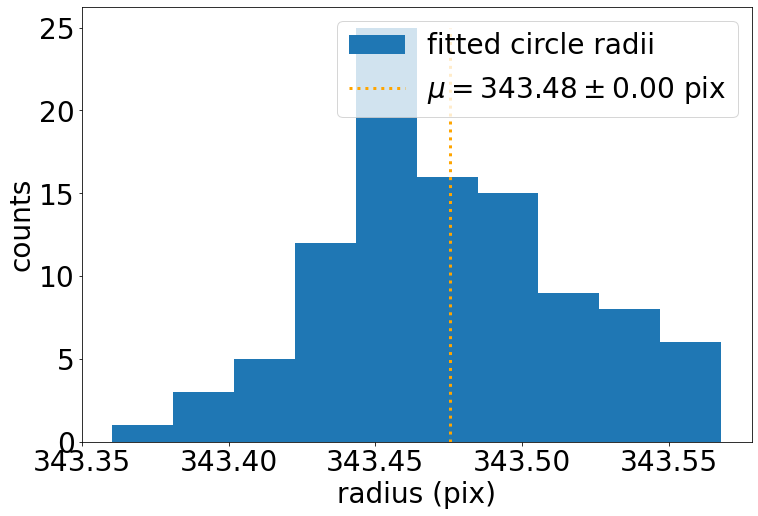

(343.475622213237, 0.04252777771309049, 0.004252777771309049)

In [42]:
print(len(circle_radii), "radii")


hist_and_gaussFit(
    circle_radii, 
    label="fitted circle radii", 
    bins=10, 
    xlabel="radius (pix)", 
    ylabel="normalized counts",
    # pixel_to_arcsec=True
)

Absolute radius of the fitted circle (3 LEDs)

100 radii
mean: 343.4998958033705 pix
std: 0.06608284994588458 pix
mean error: 0.0066082849945884575  pix

popt: 	 mu: 343.49842 pix, sigma: -0.03823 pix
perr: 	 mu: 0.00360 pix, sigma: 0.00294 pix


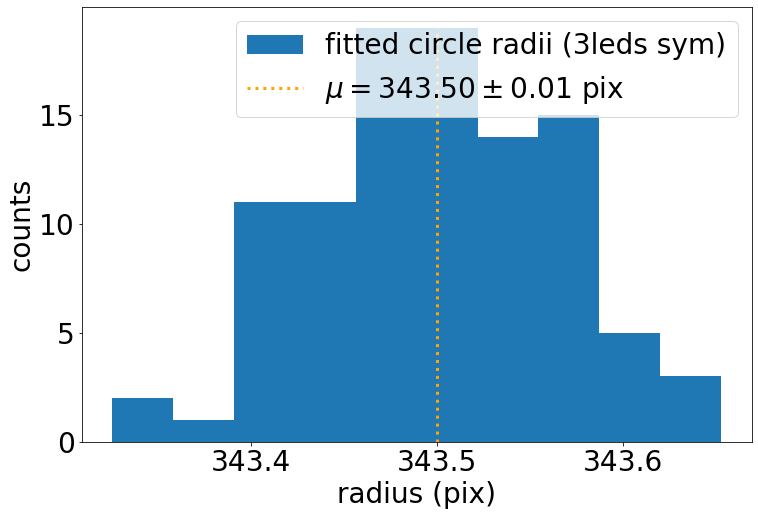

In [43]:
print(len(circle_radii_off), "radii")


msmE_r = hist_and_gaussFit(
    circle_radii_off, 
    label=f"fitted circle radii (3leds {CONSTELLATION_3LED})", 
    bins=10, 
    xlabel="radius (pix)", 
    ylabel="normalized counts",
    # pixel_to_arcsec=True
)

In [44]:
latex_table(msmE_r)

means:
$343.500 \pm 0.007$
std:
$0.066$


Calculating the difference between the mean circle radius fitted to 8 LEDs and to 3 LEDs by hand

In [45]:
l8 = 343.476
s_as = np.array([343.500, 343.179])

print("mean:")
print(s_as - l8, "pix")
print(chip_to_arcsec(s_as - l8), "arcsec")

print("std:")
print(chip_to_arcsec(np.array([0.043, 0.066, 0.179])), "arcsec")

mean:
[ 0.024 -0.297] pix
[ 0.53463838 -6.61614993] arcsec
std:
[0.95789376 1.47025554 3.98751123] arcsec


In [46]:
print("343.305 - 343.476 = ",end=" ")
print(343.305 - 343.476, "pix", end=" ")
print(chip_to_arcsec(343.305 - 343.476), "arcsec")

print("std:")
print(chip_to_arcsec(np.array([0.022, 0.043])), "arcsec")

343.305 - 343.476 =  -0.17099999999999227 pix -3.8092984417712032 arcsec
std:
[0.49008518 0.95789376] arcsec


Absolute centre position of the fitted circle, x and y coordinates separately

100 center x-positions
mean: 1413.4602307607593 pix
std: 0.04045082604426303 pix
mean error: 0.0040450826044263035  pix

popt: 	 mu: 1413.45126 pix, sigma: -0.02534 pix
perr: 	 mu: 0.00159 pix, sigma: 0.00130 pix
100 center y-positions
mean: 1844.9272465038732 pix
std: 0.03808730473712295 pix
mean error: 0.003808730473712295  pix

popt: 	 mu: 1844.91758 pix, sigma: -0.01581 pix
perr: 	 mu: 0.00079 pix, sigma: 0.00058 pix


[]

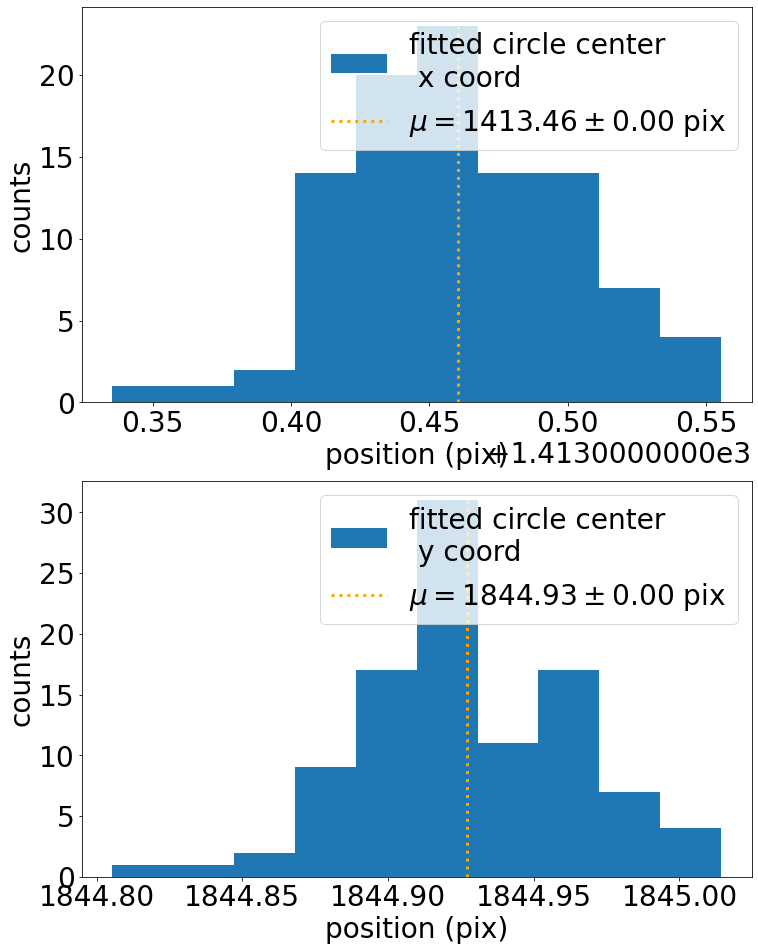

In [47]:
fig, (ax1, ax2) = plt.subplots(figsize=(12*ncols,8*nrows), nrows=nrows, ncols=ncols)

c_pos_x = np.array(circle_center)[:,0] # np.reshape(circle_center, (-1))
# print(c_pos_x)
print(len(c_pos_x), "center x-positions")


hist_and_gaussFit(
    c_pos_x, 
    label="fitted circle center \n x coord", 
    bins=10, 
    ax=ax1,
    xlabel="position (pix)", 
    ylabel="normalized counts",
    autoplot=False,
    # pixel_to_arcsec=True
)

c_pos_y = np.array(circle_center)[:,1] # np.reshape(circle_center, (-1))
# print(c_pos_y)
print(len(c_pos_y), "center y-positions")


hist_and_gaussFit(
    c_pos_y, 
    label="fitted circle center \n y coord", 
    bins=10, 
    ax=ax2,
    xlabel="position (pix)", 
    ylabel="normalized counts",
    autoplot=False,
    # pixel_to_arcsec=True
)

plt.plot()


Absolute centre position of the fitted circle (only 3 leds), x and y coordinates separately

100 center x-positions
mean: 1413.4654345703125 pix
std: 0.06846543207221846 pix
mean error: 0.006846543207221846  pix

popt: 	 mu: 1413.44592 pix, sigma: -0.02229 pix
perr: 	 mu: 0.00220 pix, sigma: 0.00174 pix
100 center y-positions
mean: 1844.925479736328 pix
std: 0.061867819543023624 pix
mean error: 0.0061867819543023625  pix

popt: 	 mu: 1844.94363 pix, sigma: 0.03834 pix
perr: 	 mu: 0.00340 pix, sigma: 0.00278 pix


[]

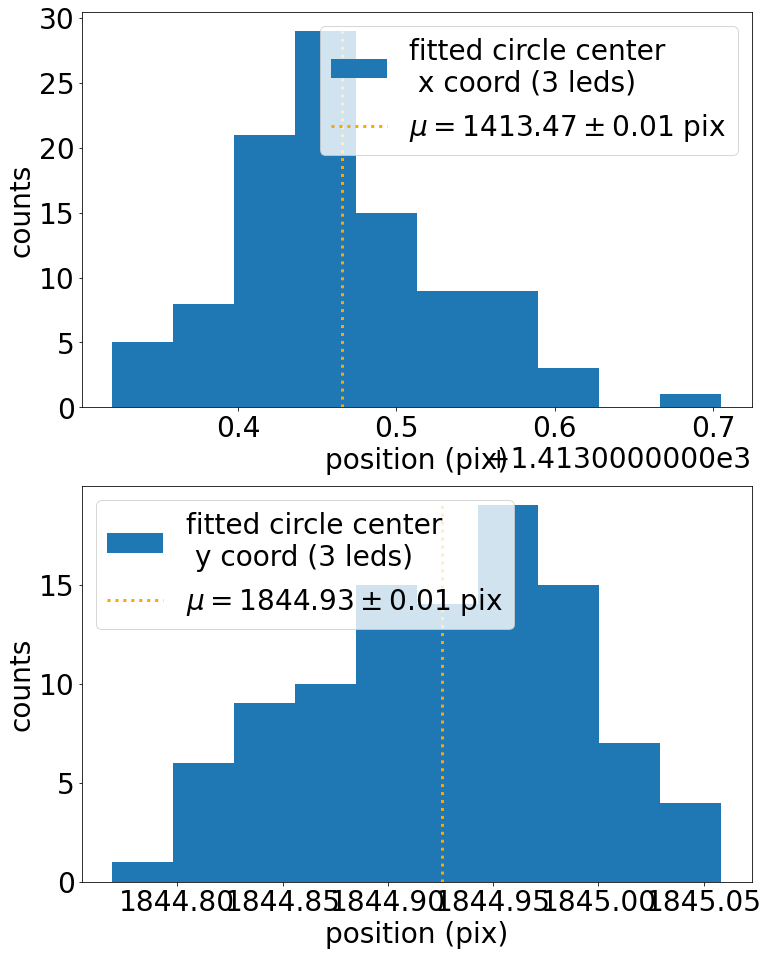

In [48]:
fig, (ax1, ax2) = plt.subplots(figsize=(12*ncols,8*nrows), nrows=nrows, ncols=ncols)

c_pos_x = np.array(circle_center_off)[:,0] # np.reshape(circle_center, (-1))
# print(c_pos_x)
print(len(c_pos_x), "center x-positions")


hist_and_gaussFit(
    c_pos_x, 
    label="fitted circle center \n x coord (3 leds)", 
    bins=10, 
    ax=ax1,
    xlabel="position (pix)", 
    ylabel="normalized counts",
    autoplot=False,
    # pixel_to_arcsec=True
)

c_pos_y = np.array(circle_center_off)[:,1] # np.reshape(circle_center, (-1))
# print(c_pos_y)
print(len(c_pos_y), "center y-positions")


hist_and_gaussFit(
    c_pos_y, 
    label="fitted circle center \n y coord (3 leds)", 
    bins=10, 
    ax=ax2,
    xlabel="position (pix)", 
    ylabel="normalized counts",
    autoplot=False,
    # pixel_to_arcsec=True
)

plt.plot()


In [49]:
def latex_table(mean_std_meanErr):
    print("means:")
    print(f"${mean_std_meanErr[0]:.3f} \pm {mean_std_meanErr[2]:.3f}$")
    print("std:")
    print(f"${mean_std_meanErr[1]:.3f}$")


Difference of centre position of the fitted circle between all leds on and only 3 leds on, x and y coordinates separately  

For turned off LEDs:  
plot `center_off - center_all` to see how much it shifts

100 center x-positions
mean: 0.005203809553290739 pix
std: 0.05535733862459262 pix
mean error: 0.005535733862459262  pix

popt: 	 mu: -0.00544 pix, sigma: 0.03593 pix
perr: 	 mu: 0.00310 pix, sigma: 0.00253 pix

mean: 0.11592317907968076 arcsec
std: 1.233173238381702 arcsec
mean error: 0.1233173238381702  arcsec

popt: 	 mu: -0.12126 arcsec, sigma: 0.80048 arcsec
perr: 	 mu: 0.06902 arcsec, sigma: 0.05638 arcsec
100 center y-positions
mean: -0.0017667675448456066 pix
std: 0.05306404240232817 pix
mean error: 0.005306404240232817  pix

popt: 	 mu: -0.00012 pix, sigma: -0.03394 pix
perr: 	 mu: 0.00271 pix, sigma: 0.00222 pix

mean: -0.03935757225469361 arcsec
std: 1.1820863978788239 arcsec
mean error: 0.11820863978788237  arcsec

popt: 	 mu: -0.00276 arcsec, sigma: -0.75615 arcsec
perr: 	 mu: 0.06045 arcsec, sigma: 0.04936 arcsec


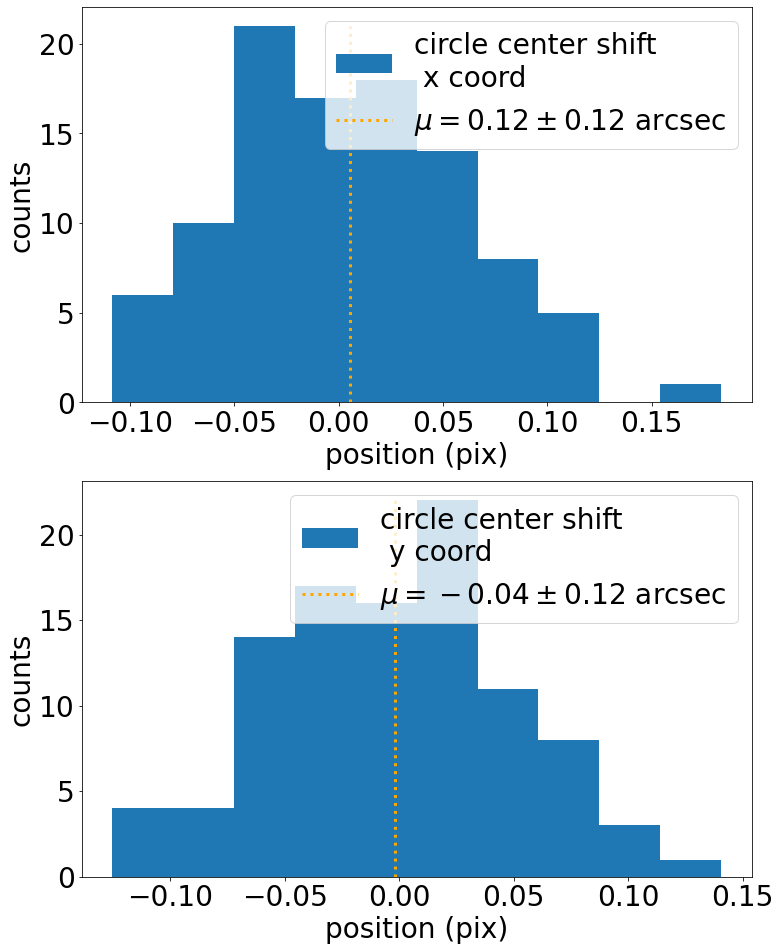

In [50]:
fig, (ax1, ax2) = plt.subplots(figsize=(12*ncols,8*nrows), nrows=nrows, ncols=ncols)

center_diff = np.array(circle_center_off) - np.array(circle_center)

c_pos_x = center_diff[:,0] # np.reshape(circle_center, (-1))
# print(c_pos_x)
print(len(c_pos_x), "center x-positions")


msmEx = hist_and_gaussFit(
    c_pos_x, 
    label="circle center shift \n x coord", 
    bins=10, 
    ax=ax1,
    xlabel="position (pix)", 
    ylabel="normalized counts",
    autoplot=False,
    pixel_to_arcsec=True
)

c_pos_y = center_diff[:,1] # np.reshape(circle_center, (-1))
# print(c_pos_y)
print(len(c_pos_y), "center y-positions")


msmEy = hist_and_gaussFit(
    c_pos_y, 
    label="circle center shift \n y coord", 
    bins=10, 
    ax=ax2,
    xlabel="position (pix)", 
    ylabel="normalized counts",
    autoplot=False,
    pixel_to_arcsec=True
)

plt.plot()


fig.savefig(f"{PLOT_PATH}sim_center_3-8leds_{CONSTELLATION_3LED}.pdf")

In [51]:
latex_table(msmEx)
print("\ny:")
latex_table(msmEy)


means:
$0.116 \pm 0.123$
std:
$1.233$

y:
means:
$-0.039 \pm 0.118$
std:
$1.182$


Difference of centre position the fitted circle to the nominal center position, x and y coordinates separately  
`circle_centre - true_sc_centre`

100 center x-positions
mean: 0.17337050406008075 pix
std: 0.04045082604426303 pix
mean error: 0.0040450826044263035  pix

popt: 	 mu: 0.16440 pix, sigma: -0.02534 pix
perr: 	 mu: 0.00159 pix, sigma: 0.00130 pix

mean: 3.862105210322711 arcsec
std: 0.9011068340279306 arcsec
mean error: 0.09011068340279306  arcsec

popt: 	 mu: 3.66220 arcsec, sigma: -0.56453 arcsec
perr: 	 mu: 0.03549 arcsec, sigma: 0.02898 arcsec


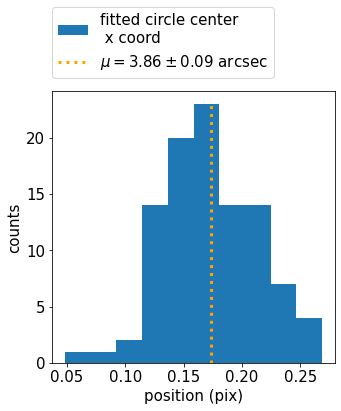

100 center y-positions
mean: 0.20353491714283792 pix
std: 0.03808730473712295 pix
mean error: 0.003808730473712295  pix

popt: 	 mu: 0.19387 pix, sigma: -0.01580 pix
perr: 	 mu: 0.00079 pix, sigma: 0.00058 pix

mean: 4.5340657468905174 arcsec
std: 0.8484556174642922 arcsec
mean error: 0.08484556174642922  arcsec

popt: 	 mu: 4.31874 arcsec, sigma: -0.35199 arcsec
perr: 	 mu: 0.01755 arcsec, sigma: 0.01290 arcsec


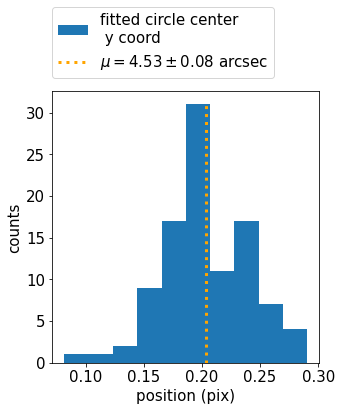

In [53]:
setFonts(15)
fs = (5, 6)


# fig, (ax1, ax2) = plt.subplots(figsize=(12*ncols,8*nrows), nrows=nrows, ncols=ncols)
fig, ax1 = plt.subplots(figsize=fs)

c_diff = np.array(circle_center) - true_sc_centre

c_diff_x = c_diff[:,0]
print(len(c_diff_x), "center x-positions")
# print(c_diff_x)


cx_mean, cx_std, cx_mean_err = hist_and_gaussFit(
    c_diff_x, 
    label="fitted circle center \n x coord", 
    bins=10, 
    ax=ax1,
    xlabel="position (pix)", # "$x$ coordinate (pix)"
    ylabel="normalized counts",
    autoplot=False,
    pixel_to_arcsec=True,
    force_return_in_pix=True
)
# print(cx_mean)
# print(cx_std)
# print(cx_mean_err)
ax1.legend(loc=(.0, 1.05))
plt.tight_layout()
plt.show()

fig.savefig(f"{PLOT_PATH}sim_circleCenter-nominal-x.pdf")

fig, ax2 = plt.subplots(figsize=fs)

c_diff_y = c_diff[:,1]
print(len(c_diff_y), "center y-positions")
# print(c_diff_y)

cy_mean, cy_std, cy_mean_err = hist_and_gaussFit(
    c_diff_y, 
    label="fitted circle center \n y coord", 
    bins=10, 
    ax=ax2,
    xlabel="position (pix)", 
    ylabel="normalized counts",
    autoplot=False,
    pixel_to_arcsec=True,
    force_return_in_pix=True
)
ax2.legend(loc=(.0, 1.05))
plt.tight_layout()
plt.show()

fig.savefig(f"{PLOT_PATH}sim_circleCenter-nominal-y.pdf")

Difference of centre position of the fitted circle to the true center position  (3 leds), x and y coordinates separately  
`circle_centre_off - true_sc_centre`

100 center x-positions
mean: 0.17857431361337148 pix
std: 0.06846543207221846 pix
mean error: 0.006846543207221846  pix

popt: 	 mu: 0.15906 pix, sigma: -0.02229 pix
perr: 	 mu: 0.00220 pix, sigma: 0.00174 pix

mean: 3.978028389402392 arcsec
std: 1.5251769807479867 arcsec
mean error: 0.15251769807479867  arcsec

popt: 	 mu: 3.54342 arcsec, sigma: -0.49652 arcsec
perr: 	 mu: 0.04892 arcsec, sigma: 0.03871 arcsec
100 center y-positions
mean: 0.2017681495979923 pix
std: 0.06186781954302364 pix
mean error: 0.006186781954302363  pix

popt: 	 mu: 0.21992 pix, sigma: 0.03835 pix
perr: 	 mu: 0.00340 pix, sigma: 0.00278 pix

mean: 4.494708174635824 arcsec
std: 1.378204611584986 arcsec
mean error: 0.1378204611584986  arcsec

popt: 	 mu: 4.89916 arcsec, sigma: 0.85430 arcsec
perr: 	 mu: 0.07573 arcsec, sigma: 0.06185 arcsec


[]

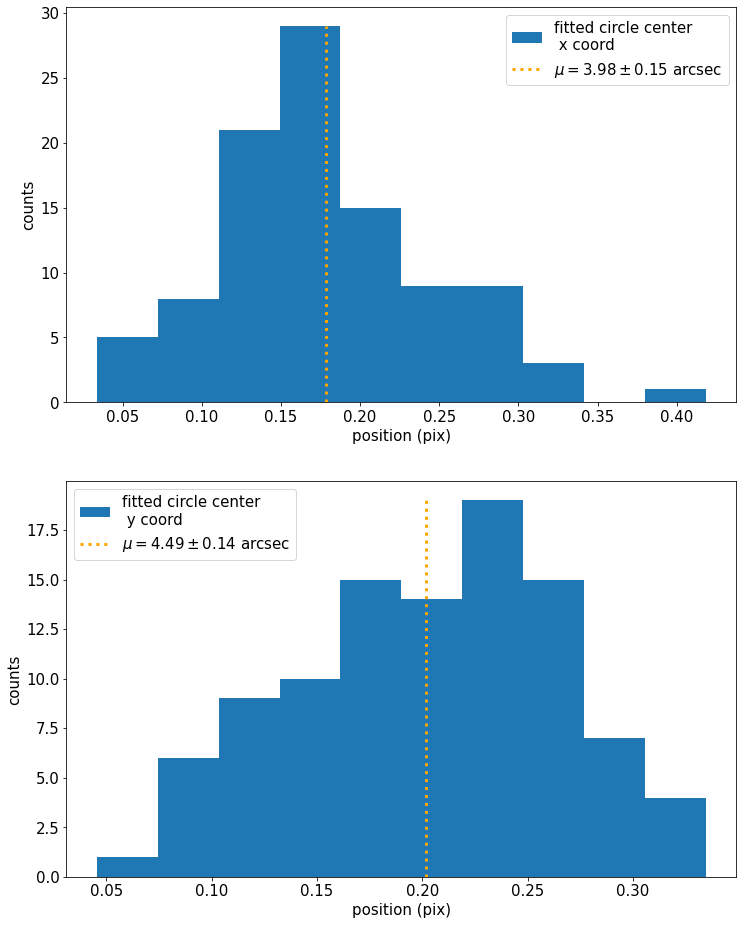

In [54]:
fig, (ax1, ax2) = plt.subplots(figsize=(12*ncols,8*nrows), nrows=nrows, ncols=ncols)

c_diff = np.array(circle_center_off) - true_sc_centre

c_diff_x = c_diff[:,0]
print(len(c_diff_x), "center x-positions")
# print(c_diff_x)


cx_off_mean, cx_off_std, cx_off_mean_err = hist_and_gaussFit(
    c_diff_x, 
    label="fitted circle center \n x coord", 
    bins=10, 
    ax=ax1,
    xlabel="position (pix)", 
    ylabel="normalized counts",
    autoplot=False,
    pixel_to_arcsec=True,
    force_return_in_pix=True
)

c_diff_y = c_diff[:,1]
print(len(c_diff_y), "center y-positions")
# print(c_diff_y)

cy_off_mean, cy_off_std, cy_off_mean_err = hist_and_gaussFit(
    c_diff_y, 
    label="fitted circle center \n y coord", 
    bins=10, 
    ax=ax2,
    xlabel="position (pix)", 
    ylabel="normalized counts",
    autoplot=False,
    pixel_to_arcsec=True,
    force_return_in_pix=True
)


plt.plot()

Residuum as the distance of the extracted led positions from the fitted circle  

`distance_led_to_centre - circle_radius`  

$d_\mathrm{led} = \sqrt{(x_\mathrm{led} - x_\mathrm{centre})^2 + (y_\mathrm{led} - y_\mathrm{centre})^2}$  

$res = d_\mathrm{led} - r$

All leds in one histogram

100 positions
100 radii
(800,)
(800,)
residuum: (800,)

mean: 4.026309457771049e-05 pix
std: 0.16415520551523186 pix
mean error: 0.0058037629493445896  pix

popt: 	 mu: -0.04299 pix, sigma: -0.02572 pix
perr: 	 mu: 0.00189 pix, sigma: 0.00152 pix

mean: 0.0008969248154138366 arcsec
std: 3.656819699285571 arcsec
mean error: 0.12928810034706892  arcsec

popt: 	 mu: -0.95762 arcsec, sigma: -0.57296 arcsec
perr: 	 mu: 0.04205 arcsec, sigma: 0.03376 arcsec


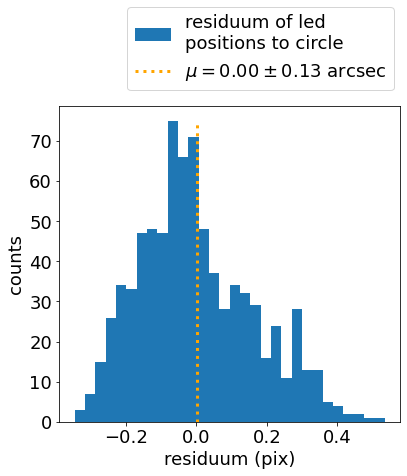

In [58]:


# pos = np.reshape(led_positions_diff, (-1))
print(len(led_positions), "positions")
print(len(circle_radii), "radii")

n_leds = np.shape(led_positions)[1]

d_led = []

for led in range(n_leds):
    vec_led = np.array(led_positions)[:,led] - np.array(circle_center)
    # print(vec_led.shape)
    # print(vec_led)

    # d_led.append(np.sqrt( np.sum(vec_led**2, axis=1) ))
    d_led = np.append(d_led, np.sqrt( np.sum(vec_led**2, axis=1) ))
    # print(np.shape(d_led))

print(np.shape(d_led))
# print(d_led)

# print(np.array(d_led))
# print(np.tile(circle_radii, n_leds))
tiled_circle_radii = np.tile(circle_radii, n_leds).reshape(np.shape(d_led))
print(tiled_circle_radii.shape)
residuum = np.array(d_led) - tiled_circle_radii

print("residuum:", residuum.shape)
# print(residuum)


setFonts(18)
fig, ax = plt.subplots(figsize=(6,7))

print("")
hist_and_gaussFit(
    residuum, 
    label="residuum of led \npositions to circle", 
    bins=30, 
    xlabel="residuum (pix)", 
    ylabel="counts",
    pixel_to_arcsec=True,
    ax=ax,
    autoplot=False
)

ax.legend(loc=(.2, 1.05))
plt.tight_layout()
plt.show()

fig.savefig(f"{PLOT_PATH}sim_residuum_hist.pdf")

Each led separately

100 positions
100 radii
(8, 100)
(8, 100)
residuum: (8, 100)

mean: 0.0076417461814395436 pix
std: 0.09956315261634309 pix
mean error: 0.009956315261634308  pix

popt: 	 mu: 0.02398 pix, sigma: 0.02641 pix
perr: 	 mu: 0.00227 pix, sigma: 0.00170 pix

mean: 0.17023211591444454 arcsec
std: 2.21792843344609 arcsec
mean error: 0.22179284334460897  arcsec

popt: 	 mu: 0.53409 arcsec, sigma: 0.58842 arcsec
perr: 	 mu: 0.05065 arcsec, sigma: 0.03795 arcsec


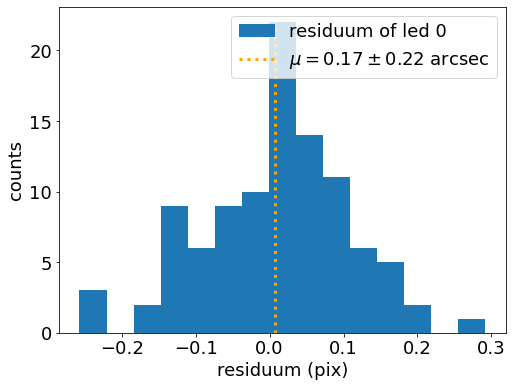


mean: -0.00691161679151378 pix
std: 0.09794541018914499 pix
mean error: 0.009794541018914499  pix

popt: 	 mu: -0.00202 pix, sigma: -0.03663 pix
perr: 	 mu: 0.00324 pix, sigma: 0.00264 pix

mean: -0.15396731622242288 arcsec
std: 2.1818906339892874 arcsec
mean error: 0.21818906339892877  arcsec

popt: 	 mu: -0.04507 arcsec, sigma: -0.81592 arcsec
perr: 	 mu: 0.07210 arcsec, sigma: 0.05887 arcsec


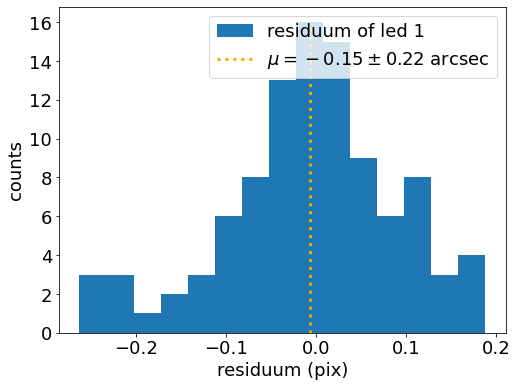


mean: 0.1710132686733391 pix
std: 0.10703239642771005 pix
mean error: 0.010703239642771005  pix

popt: 	 mu: 0.18716 pix, sigma: 0.05637 pix
perr: 	 mu: 0.00684 pix, sigma: 0.00558 pix

mean: 3.809594022687604 arcsec
std: 2.3843177832229943 arcsec
mean error: 0.2384317783222994  arcsec

popt: 	 mu: 4.16920 arcsec, sigma: 1.25569 arcsec
perr: 	 mu: 0.15234 arcsec, sigma: 0.12438 arcsec


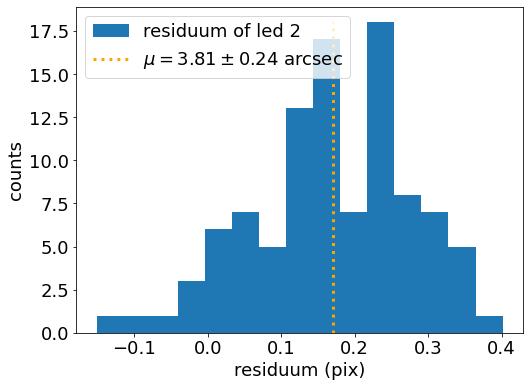


mean: -0.09573089092742805 pix
std: 0.09709480604163957 pix
mean error: 0.009709480604163958  pix

popt: 	 mu: -0.06677 pix, sigma: 0.02158 pix
perr: 	 mu: 0.00152 pix, sigma: 0.00154 pix

mean: -2.1325586762528492 arcsec
std: 2.162942066424044 arcsec
mean error: 0.21629420664240445  arcsec

popt: 	 mu: -1.48752 arcsec, sigma: 0.48071 arcsec
perr: 	 mu: 0.03389 arcsec, sigma: 0.03422 arcsec


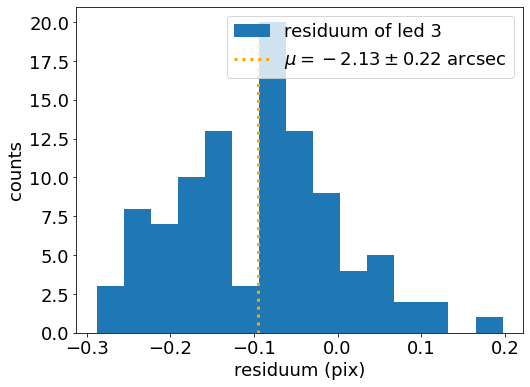


mean: 0.24988007303470397 pix
std: 0.10770289346808903 pix
mean error: 0.010770289346808903  pix

popt: 	 mu: 0.27792 pix, sigma: 0.04235 pix
perr: 	 mu: 0.00432 pix, sigma: 0.00352 pix

mean: 5.566478203747458 arcsec
std: 2.399254176972281 arcsec
mean error: 0.23992541769722806  arcsec

popt: 	 mu: 6.19101 arcsec, sigma: 0.94337 arcsec
perr: 	 mu: 0.09615 arcsec, sigma: 0.07850 arcsec


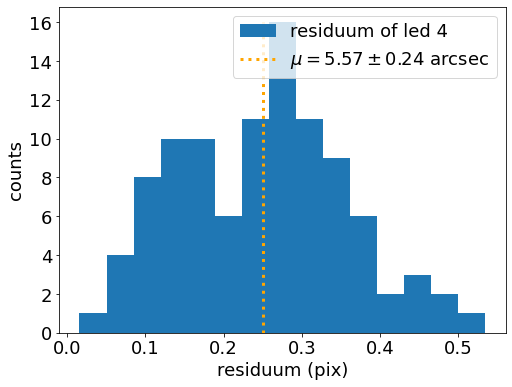


mean: -0.10328382331113745 pix
std: 0.10491703618285958 pix
mean error: 0.010491703618285959  pix

popt: 	 mu: -0.08119 pix, sigma: 0.06275 pix
perr: 	 mu: 0.00731 pix, sigma: 0.00597 pix

mean: -2.3008123228029587 arcsec
std: 2.33719475114993 arcsec
mean error: 0.233719475114993  arcsec

popt: 	 mu: -1.80866 arcsec, sigma: 1.39779 arcsec
perr: 	 mu: 0.16294 arcsec, sigma: 0.13308 arcsec


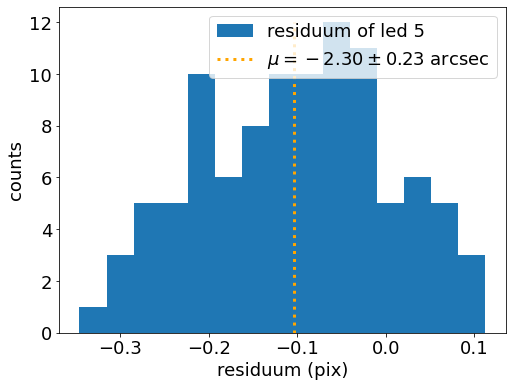


mean: -0.11653443721709891 pix
std: 0.08686497949441974 pix
mean error: 0.008686497949441974  pix

popt: 	 mu: -0.12229 pix, sigma: 0.06294 pix
perr: 	 mu: 0.00710 pix, sigma: 0.00580 pix

mean: -2.595990936279527 arcsec
std: 1.9350563218280443 arcsec
mean error: 0.19350563218280445  arcsec

popt: 	 mu: -2.72410 arcsec, sigma: 1.40198 arcsec
perr: 	 mu: 0.15813 arcsec, sigma: 0.12913 arcsec


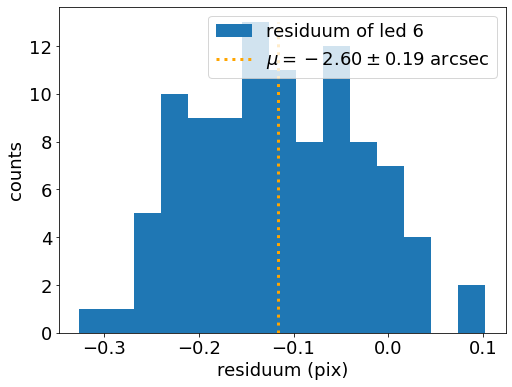


mean: -0.10575221488568275 pix
std: 0.09577659576463064 pix
mean error: 0.009577659576463064  pix

popt: 	 mu: -0.07612 pix, sigma: 0.02797 pix
perr: 	 mu: 0.00241 pix, sigma: 0.00191 pix

mean: -2.355799692268438 arcsec
std: 2.133576824586985 arcsec
mean error: 0.21335768245869846  arcsec

popt: 	 mu: -1.69572 arcsec, sigma: 0.62306 arcsec
perr: 	 mu: 0.05374 arcsec, sigma: 0.04260 arcsec


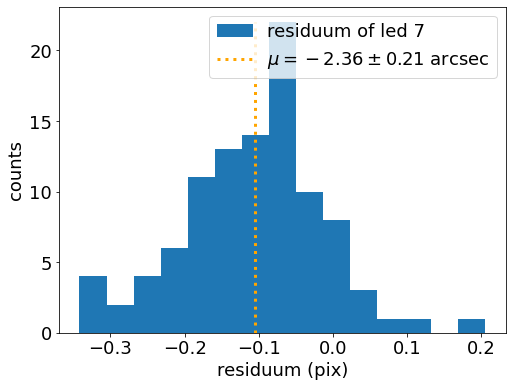

(8, 3)


In [59]:
# pos = np.reshape(led_positions_diff, (-1))
print(len(led_positions), "positions")
print(len(circle_radii), "radii")

n_leds = np.shape(led_positions)[1]

d_led = []

for led in range(n_leds):
    vec_led = np.array(led_positions)[:,led] - np.array(circle_center)
    # print(vec_led.shape)
    # print(vec_led)

    d_led.append(np.sqrt( np.sum(vec_led**2, axis=1) ))
    # d_led = np.append(d_led, np.sqrt( np.sum(vec_led**2, axis=1) ))
    # print(np.shape(d_led))

print(np.shape(d_led))
# print(d_led)

# print(np.array(d_led))
# print(np.tile(circle_radii, n_leds))
tiled_circle_radii = np.tile(circle_radii, n_leds).reshape(np.shape(d_led))
print(tiled_circle_radii.shape)
residuum = np.array(d_led) - tiled_circle_radii

print("residuum:", residuum.shape)
# print(residuum)


led_means_stds = []

for n_led in range(len(residuum)):
    fig, ax = plt.subplots(figsize=(8, 6))
    print("")
    mean_std_meanerr = hist_and_gaussFit(
        residuum[n_led], 
        label=f"residuum of led {n_led}", 
        bins=15, 
        ax=ax,
        xlabel="residuum (pix)", 
        ylabel="normalized counts",
        pixel_to_arcsec=True
    )
    led_means_stds.append(list(mean_std_meanerr))

print(np.shape(led_means_stds))

Plot the mean residuum for each LED with standard error on the mean as errorbars

[2, 1, 6, 7, 5, 3, 0, 4]
[0, 1, 3, 4, 5, 7, 8, 10]
0.0008969248154138687 arcsec
1.0993656422992784 arcsec


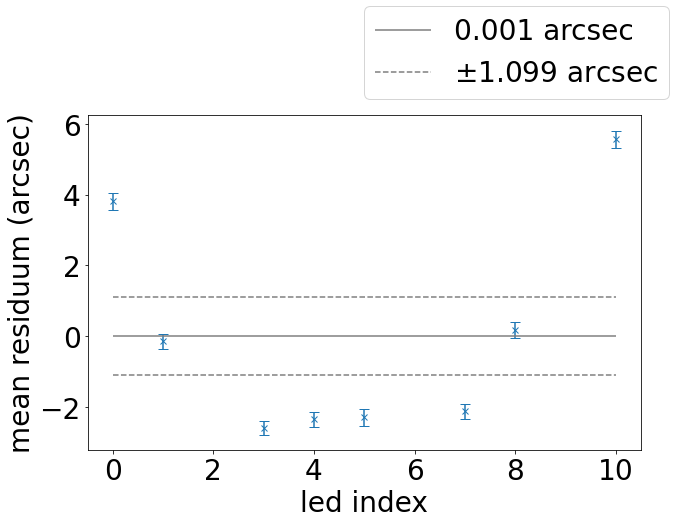

In [60]:
setFonts(28)

unit = "arcsec"
fig, ax = plt.subplots(figsize=(10,8))

print(extr_indices[-1])
print(constr_indices[-1])
# for led_idx, msm in enumerate(led_means_stds):
for led_extr, led_constr in zip(extr_indices[-1], constr_indices[-1]):

    led_idx = led_constr
    msm = led_means_stds[led_extr]

    ax.errorbar(
        led_idx, msm[0], 
        yerr=msm[2],
        fmt="x", color="tab:blue", 
        capsize=5,
        # ecolor="cyan",
        # label=fr"$\rho_y = {100 * corr_coeff_y[0] :.1f} \%$", 
    )


means = np.array(led_means_stds)[:, 0]
mean_trend = means.mean()
mean_std = means.std(ddof=1)
mean_trend_err = mean_std / np.sqrt(len(means))

print(mean_trend, unit) 
print(mean_trend_err, unit)

# ax.hlines(0.0, 0, len(led_means_stds)-1, linestyles="dashed", color="tab:blue", )
ax.hlines(mean_trend, np.min(constr_indices[-1]), np.max(constr_indices[-1]), linestyles="solid", color="tab:gray", label=f"{mean_trend :.3f} {unit}")
ax.hlines([mean_trend - mean_trend_err, mean_trend + mean_trend_err], np.min(constr_indices[-1]), np.max(constr_indices[-1]), linestyles="dashed", color="tab:gray", label=fr"$\pm${mean_trend_err :.3f} {unit}")



ax.set_xlabel("led index")
ax.set_ylabel(f"mean residuum ({unit})")


ax.legend(loc=(.5, 1.05))

# ax.set_aspect("equal", adjustable="datalim")
# ax.grid()

plt.tight_layout()
plt.show()


fig.savefig(f"{PLOT_PATH}sim_residuum-ledIndex.pdf")

Residuum with 3 LEDs

All in one

100 positions
100 radii
(300,)
(300,)
residuum: (300,)

mean: 2.423748173441709e-05 pix
std: 0.1292362940690002 pix
mean error: 0.007461460916980689  pix

popt: 	 mu: -0.03244 pix, sigma: 0.06517 pix
perr: 	 mu: 0.00606 pix, sigma: 0.00495 pix

mean: 0.0005399286631776443 arcsec
std: 2.87894510887339 arcsec
mean error: 0.1662159733590208  arcsec

popt: 	 mu: -0.72274 arcsec, sigma: 1.45185 arcsec
perr: 	 mu: 0.13510 arcsec, sigma: 0.11031 arcsec


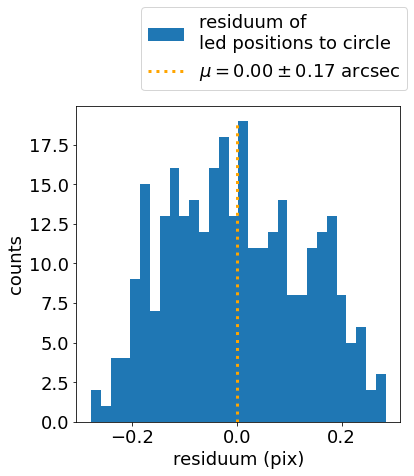

In [61]:
# pos = np.reshape(led_positions_diff, (-1))
print(len(led_positions_off), "positions")
print(len(circle_radii_off), "radii")

n_leds = np.shape(led_positions_off)[1]

d_led = []

for led in range(n_leds):
    vec_led = np.array(led_positions_off)[:,led] - np.array(circle_center_off)
    # print(vec_led.shape)
    # print(vec_led)

    # d_led.append(np.sqrt( np.sum(vec_led**2, axis=1) ))
    d_led = np.append(d_led, np.sqrt( np.sum(vec_led**2, axis=1) ))
    # print(np.shape(d_led))

print(np.shape(d_led))
# print(d_led)

# print(np.array(d_led))
# print(np.tile(circle_radii_off, n_leds))
tiled_circle_radii = np.tile(circle_radii_off, n_leds).reshape(np.shape(d_led))
print(tiled_circle_radii.shape)
residuum = np.array(d_led) - tiled_circle_radii

print("residuum:", residuum.shape)
# print(residuum)

setFonts(18)

fig, ax = plt.subplots(figsize=(6,7))

print("")
hist_and_gaussFit(
    residuum, 
    label="residuum of \nled positions to circle", 
    bins=30, 
    xlabel="residuum (pix)", 
    ylabel="counts",
    pixel_to_arcsec=True,
    ax=ax,
    autoplot=False
)

ax.legend(loc=(.2, 1.05))
plt.tight_layout()
plt.show()

fig.savefig(f"{PLOT_PATH}sim_residuum_hist-3leds-{CONSTELLATION_3LED}.pdf")

each LED separately

100 positions
100 radii
(3, 100)
(3, 100)
residuum: (3, 100)

mean: 0.14153136895746002 pix
std: 0.06864911476722804 pix
mean error: 0.006864911476722804  pix

popt: 	 mu: 0.15398 pix, sigma: 0.04888 pix
perr: 	 mu: 0.00405 pix, sigma: 0.00331 pix

mean: 3.152837562756854 arcsec
std: 1.529268806501673 arcsec
mean error: 0.1529268806501673  arcsec

popt: 	 mu: 3.43023 arcsec, sigma: 1.08897 arcsec
perr: 	 mu: 0.09024 arcsec, sigma: 0.07383 arcsec


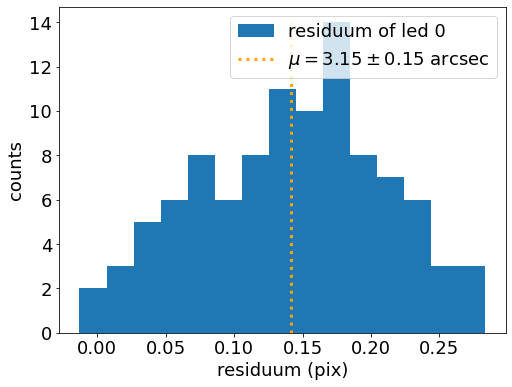


mean: -0.1289565743202968 pix
std: 0.06446802296317077 pix
mean error: 0.0064468022963170765  pix

popt: 	 mu: -0.12922 pix, sigma: 0.04938 pix
perr: 	 mu: 0.00405 pix, sigma: 0.00331 pix

mean: -2.872713904178253 arcsec
std: 1.4361283006882317 arcsec
mean error: 0.1436128300688232  arcsec

popt: 	 mu: -2.87862 arcsec, sigma: 1.10010 arcsec
perr: 	 mu: 0.09028 arcsec, sigma: 0.07381 arcsec


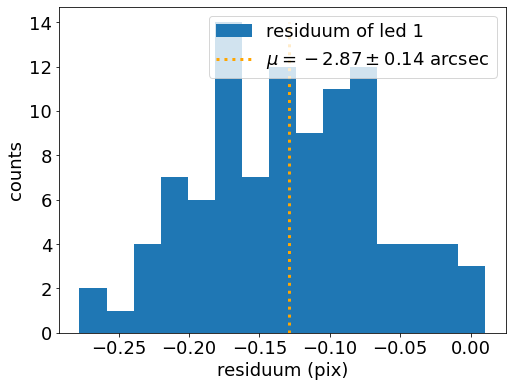


mean: -0.012502082191959972 pix
std: 0.06622332500660097 pix
mean error: 0.006622332500660097  pix

popt: 	 mu: -0.01434 pix, sigma: 0.04182 pix
perr: 	 mu: 0.00342 pix, sigma: 0.00279 pix

mean: -0.27850387258906895 arcsec
std: 1.4752304605647042 arcsec
mean error: 0.14752304605647043  arcsec

popt: 	 mu: -0.31951 arcsec, sigma: 0.93163 arcsec
perr: 	 mu: 0.07615 arcsec, sigma: 0.06218 arcsec


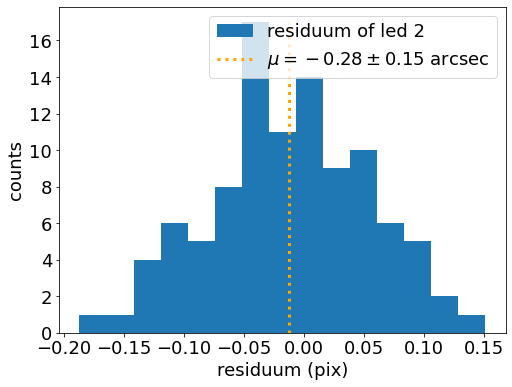

(8, 3)


In [64]:
# pos = np.reshape(led_positions_diff, (-1))
print(len(led_positions_off), "positions")
print(len(circle_radii_off), "radii")

n_leds = np.shape(led_positions_off)[1]

d_led = []

for led in range(n_leds):
    vec_led = np.array(led_positions_off)[:,led] - np.array(circle_center_off)
    # print(vec_led.shape)
    # print(vec_led)

    d_led.append(np.sqrt( np.sum(vec_led**2, axis=1) ))
    # d_led = np.append(d_led, np.sqrt( np.sum(vec_led**2, axis=1) ))
    # print(np.shape(d_led))

print(np.shape(d_led))
# print(d_led)

# print(np.array(d_led))
# print(np.tile(circle_radii, n_leds))
tiled_circle_radii = np.tile(circle_radii_off, n_leds).reshape(np.shape(d_led))
print(tiled_circle_radii.shape)
residuum = np.array(d_led) - tiled_circle_radii

print("residuum:", residuum.shape)
# print(residuum)


led_means_stds_off = []

for n_led in range(len(residuum)):
    fig, ax = plt.subplots(figsize=(8, 6))
    print("")
    mean_std_meanerr = hist_and_gaussFit(
        residuum[n_led], 
        label=f"residuum of led {n_led}", 
        bins=15, 
        ax=ax,
        xlabel="residuum (pix)", 
        ylabel="normalized counts",
        pixel_to_arcsec=True
    )
    led_means_stds_off.append(list(mean_std_meanerr))

print(np.shape(led_means_stds))

In [65]:
np.shape(led_means_stds_off)

(3, 3)

[2, 7, 0]
[0, 4, 8]
0.0005399286631773877 arcsec
1.7450135340863817 arcsec


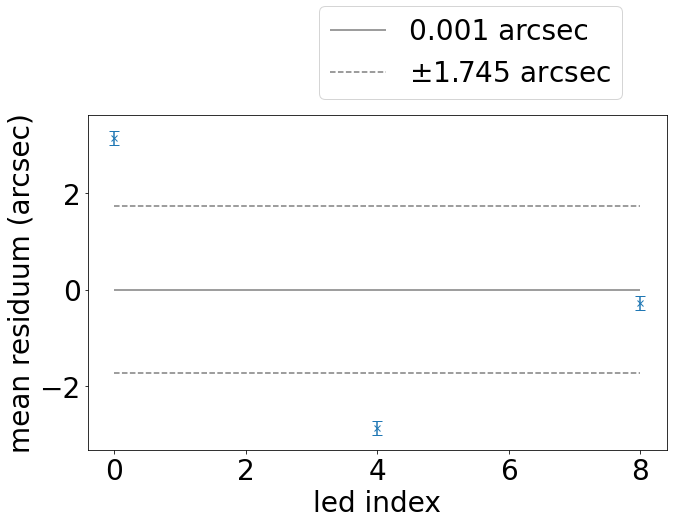

In [66]:
setFonts(28)

unit = "arcsec"
fig, ax = plt.subplots(figsize=(10,8))

print(extr_indices_off[-1])
print(constr_indices_off[-1])


for led_idx, msm in enumerate(led_means_stds_off):

    ax.errorbar(
        _constellation_indices[led_idx], msm[0], 
        yerr=msm[2],
        fmt="x", color="tab:blue", 
        capsize=5,
        # ecolor="cyan",
        # label=fr"$\rho_y = {100 * corr_coeff_y[0] :.1f} \%$", 
    )

means = np.array(led_means_stds_off)[:, 0]
mean_trend = means.mean()
mean_std = means.std(ddof=1)
mean_trend_err = mean_std / np.sqrt(len(means))

print(mean_trend, unit) 
print(mean_trend_err, unit)

# ax.hlines(0.0, 0, len(led_means_stds_off)-1, linestyles="dashed", color="tab:blue", )
ax.hlines(mean_trend, np.min(_constellation_indices), np.max(_constellation_indices), linestyles="solid", color="tab:gray", label=f"{mean_trend :.3f} {unit}")
ax.hlines([mean_trend - mean_trend_err, mean_trend + mean_trend_err], np.min(_constellation_indices), np.max(_constellation_indices), linestyles="dashed", color="tab:gray", label=fr"$\pm${mean_trend_err :.3f} {unit}")



ax.set_xlabel("led index")
ax.set_ylabel(f"mean residuum ({unit})")

# ax.plot(5, 0, color="red", marker="X", markersize=30, label="LED MATCH??")

ax.legend(loc=(.4, 1.05))

# ax.set_aspect("equal", adjustable="datalim")
# ax.grid()
plt.tight_layout()
plt.show()


fig.savefig(f"{PLOT_PATH}sim_residuum-ledIndex-3leds-{CONSTELLATION_3LED}.pdf")

Correlation between positions of 3 leds and of 8 leds

mean_x: 1413.4602307607593
std_x: 0.04045082604426303
mean error_x: 0.0040450826044263035

mean_x_off: 1413.4654345703125
std_x_off: 0.06846543207221846
mean error_x_off: 0.006846543207221846

correlation coefficient for x: (0.5884400525442673, 1.2090884630113574e-10)

cx_std: 0.04045082604426303
cx_off_std: 0.06846543207221846


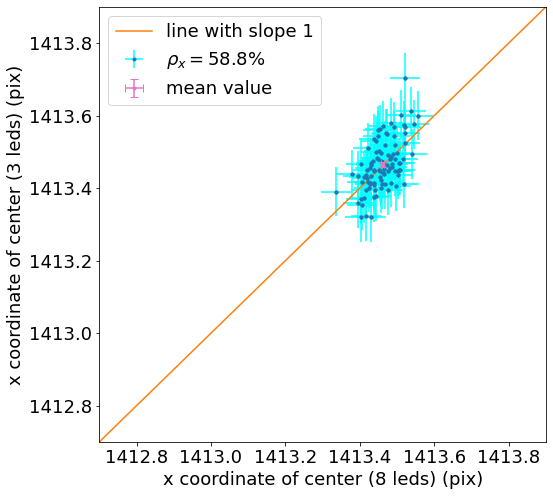



mean_y: 1844.9272465038732
std_y: 0.03808730473712295
mean error_y: 0.003808730473712295

mean_y_off: 1844.925479736328
std_y_off: 0.061867819543023624
mean error_y_off: 0.0061867819543023625

correlation coefficient for y: (0.522513103238318, 2.4594116968574207e-08)

cy_std: 0.03808730473712295
cy_off_std: 0.06186781954302364


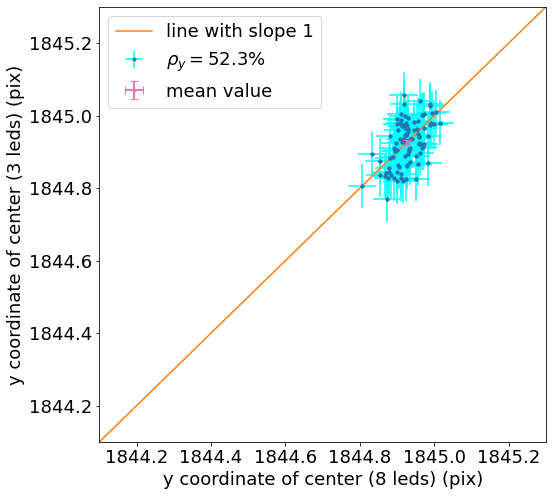

In [67]:
setFonts(18)
fs = (8, 8)
fig, ax1 = plt.subplots(figsize=fs)

c_x = np.array(circle_center)[:,0]
c_x_off = np.array(circle_center_off)[:,0]

mean_x = np.mean(c_x)
std_x = np.std(c_x, ddof=1)
mean_err_x = std_x / np.sqrt(len(c_x))

print("mean_x:", mean_x)
print("std_x:", std_x)
print("mean error_x:", mean_err_x)

mean_x_off = np.mean(c_x_off)
std_x_off = np.std(c_x_off, ddof=1)
mean_err_x_off = std_x_off / np.sqrt(len(c_x_off))

print("")
print("mean_x_off:", mean_x_off)
print("std_x_off:", std_x_off)
print("mean error_x_off:", mean_err_x_off)

## cortelation coefficient
corr_coeff_x = pearsonr(c_x, c_x_off)
print("")
print("correlation coefficient for x:", corr_coeff_x)


# ax1.set_aspect("equal", adjustable="datalim")
# ax1.set_xlim(1413.2, 1413.8)
# ax1.set_ylim(1412.7, 1414.1)

ax1.set_xlim(1412.7, 1413.9)
ax1.set_ylim(1412.7, 1413.9)

ax1.errorbar(
    c_x,            c_x_off, 
    xerr=cx_std,    yerr=cx_off_std,
    fmt=".", color="tab:blue",
    ecolor="cyan",
    label=fr"$\rho_x = {100 * corr_coeff_x[0] :.1f} \%$"
)

line_x = np.array(ax1.get_xlim()) #[np.min([c_x, c_x_off]), np.max([c_x, c_x_off])]
ax1.plot(line_x, line_x, "-", color="tab:orange", label="line with slope 1")

ax1.plot(
    c_x, c_x_off, 
    ".", color="tab:blue", 
    # label=fr"$\rho_x = {100 * corr_coeff_x[0] :.1f} \%$",
    zorder=5
)

ax1.errorbar(
    mean_x,             mean_x_off, 
    xerr=mean_err_x,    yerr=mean_err_x_off, 
    capsize=4, fmt=".", color="tab:pink", 
    label="mean value",
    zorder=10
)

ax1.set_xlabel(f"x coordinate of center ({len(filtered_led_coords)} leds) (pix)")
ax1.set_ylabel(f"x coordinate of center ({len(filtered_led_coords) - len(turn_off_led)} leds) (pix)")

ax1.legend()

print("")
print("cx_std:", cx_std)
print("cx_off_std:", cx_off_std)


ax1.ticklabel_format(useOffset=False)
plt.show()

fig.savefig(f"{PLOT_PATH}sim_center_3-8_correlation_{CONSTELLATION_3LED}-x.pdf")

######
print("\n")
######

fig, ax2 = plt.subplots(figsize=fs)

c_y = np.array(circle_center)[:,1]
c_y_off = np.array(circle_center_off)[:,1]

mean_y = np.mean(c_y)
std_y = np.std(c_y, ddof=1)
mean_err_y = std_y / np.sqrt(len(c_y))

print("mean_y:", mean_y)
print("std_y:", std_y)
print("mean error_y:", mean_err_y)

mean_y_off = np.mean(c_y_off)
std_y_off = np.std(c_y_off, ddof=1)
mean_err_y_off = std_y_off / np.sqrt(len(c_y_off))

print("")
print("mean_y_off:", mean_y_off)
print("std_y_off:", std_y_off)
print("mean error_y_off:", mean_err_y_off)

## cortelation coefficient
corr_coeff_y = pearsonr(c_y, c_y_off)
print("")
print("correlation coefficient for y:", corr_coeff_y)

# ax2.set_xlim(1844.7, 1845.2)
# ax2.set_ylim(1844.1, 1845.5)

ax2.set_xlim(1844.1, 1845.3)
ax2.set_ylim(1844.1, 1845.3)

ax2.errorbar(
    c_y,            c_y_off, 
    xerr=cy_std,    yerr=cy_off_std,
    fmt=".", color="tab:blue",
    ecolor="cyan", 
    # ecolor="cyan",
    label=fr"$\rho_y = {100 * corr_coeff_y[0] :.1f} \%$", 
    # zorder=10
)

line_y = np.array(ax2.get_xlim()) # [np.min([c_y, c_y_off]), np.max([c_y, c_y_off])]
ax2.plot(line_y, line_y, "-", color="tab:orange", label="line with slope 1")

ax2.plot(
    c_y, c_y_off, 
    ".", color="tab:blue", 
    # label=fr"$\rho_y = {100 * corr_coeff_y[0] :.1f} \%$", 
    zorder=5
)

ax2.errorbar(
    mean_y,             mean_y_off, 
    xerr=mean_err_y,    yerr=mean_err_y_off, 
    capsize=4, fmt=".", color="tab:pink", 
    elinewidth= 2,
    label="mean value",
    zorder=10
)


ax2.set_xlabel(f"y coordinate of center ({len(filtered_led_coords)} leds) (pix)")
ax2.set_ylabel(f"y coordinate of center ({len(filtered_led_coords) - len(turn_off_led)} leds) (pix)")

ax2.legend()
# ax2.set_aspect("equal", adjustable="datalim")
# ax2.grid()



print("")
print("cy_std:", cy_std)
print("cy_off_std:", cy_off_std)


ax2.ticklabel_format(useOffset=False)
plt.show()

fig.savefig(f"{PLOT_PATH}sim_center_3-8_correlation_{CONSTELLATION_3LED}-y.pdf")